# Аналитика в Яндекс.Афише

## Введение

Данное исследование направлено на оптимизацию маркетинговых затрат в Яндекс.Афише и построено на данных с июня 2017 по конец мая 2018 года:
- логе сервера с данными о посещениях сайта Яндекс.Афиши;
- выгрузке всех заказов за этот период;
- статистике рекламных расходов.

Для разработки рекомендаций по оптимизации маркетинговых затрат изучены следующие **вопросы**:
- как люди пользуются продуктом;
- когда они начинают покупать;
- сколько денег приносит каждый клиент;
- когда клиент окупается.

Иследование состоит из следующих **этапов**:
1. [Обзор данных и изучение общей информации](#step_1):
    * [Импорт библиотек](#step_1.1);
    * [Лог сервера с данными о посещениях сайта Яндекс.Афиши](#step_1.2);
    * [Выгрузка всех заказов за анализируемый период](#step_1.3);
    * [Статистика рекламных расходов](#step_1.4);
    * [Вывод](#step_1.5).
2. [Подготовка данных](#step_2):
    * [Замена названий столбцов](#step_2.1);
    * [Замена типа данных](#step_2.2);
    * [Определение и исправление ошибок в данных](#step_2.3);
    * [Вывод](#step_2.4).
3. [Построение отчётов и расчёт метрик](#step_3):
    * [Расчёт продуктовых метрик](#step_3.1);
    * [Вывод по продуктовым метрикам](#step_3.2);
    * [Торговые метрики](#step_3.3);
    * [Вывод по торговым метрикам](#step_3.4);
    * [Маркетинговые метрики](#step_3.5);
    * [Вывод по маркетинговым метрикам](#step_3.6).
4. [Общий вывод](#step_4):
    * [Метрики для Яндекс.Афиши](#step_4.1);
    * [Общая динамика показателей](#step_4.2);
    * [Показатели по типам устройств, с которых заходят пользователи](#step_4.3);
    * [Показатели по типам рекламных источников](#step_4.4).
5. [Рекомендации](#step_5).

**Результатом исследования** являются рекомендации маркетологам по суммам и направлениям денежных вложений.

## Этап 1. Обзор данных и их предобработка <a id='step_1'></a>

### Импорт библиотек <a id='step_1.1'></a>

In [1]:
import pandas as pd
import numpy as np
from IPython import display

import matplotlib.pyplot as plt
import seaborn as sns

### Лог сервера с данными о посещениях сайта Яндекс.Афиши <a id='step_1.2'></a>

In [2]:
# Прочитаем файл visits_log.csv с информацией о посещениях сайта Яндекс.Афиши и сохраним его в переменной visits
visits = pd.read_csv('C:/Users/Public/Jupyter/visits_log.csv')
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
display.display(data=visits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Данные представлены в виде таблицы, включающей в себя 359 400 строк и 5 столбцов, тип данных у трёх столбцов - < object >, у двух столбцов - целочисленные (один из них - < int >, второй - < unit >). Разберём, какие в таблице столбцы, и какую информацию они содержат:
- `Device` — категория устройства пользователя;
- `End Ts` — дата и время окончания сессии;
- `Source Id` — идентификатор рекламного источника, из которого пришел пользователь;
- `Start Ts` — дата и время начала сессии;
- `Uid` — уникальный идентификатор пользователя.

Отметим, что есть некоторое несоответствие типа данных в ряде столбцов (например, столбцы `End Ts` и `Start Ts` - это столбцы с датой и временем). Также следует привести названия столбцов в подходящий для анализа вид (привести к нижнему регистру и убрать пробелы). Отметим, что одинаковое количество значений в столбцах указывает на отсутствие в таблице пропусков.

In [4]:
visits['Device'].unique()

array(['touch', 'desktop'], dtype=object)

В столбце, описывающем категорию устройства пользователя, встречается только 2 варианта: touch и desktop.

In [5]:
visits['Source Id'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10], dtype=int64)

В столбце с идентификатором рекламного источника встречается 9 вариантов: от 1 до 10, за исключением 8.

### Выгрузка всех заказов за анализируемый период <a id='step_1.3'></a>

In [6]:
# Прочитаем файл orders_log с информацией о заказах и сохраним его в переменной orders
orders = pd.read_csv('C:/Users/Public/Jupyter/orders_log.csv')
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [7]:
display.display(data=orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Данные представлены в виде таблицы, включающей в себя 50 415 строк и 3 столбца, тип данных у одного столбца - < object >, у двух столбцов - числовые (один из них с плавающей точкой - < float >, второй целочисленный - < unit >). Разберём, какие в таблице столбцы, и какую информацию они содержат:
- `Buy Ts` — дата и время заказа;
- `Revenue` — выручка Яндекс.Афиши с этого заказа;
- `Uid` — уникальный id пользователя, который сделал заказ.

Отметим, что и в данной таблице есть несоответствие типа данных в столбце `Buy Ts` - это столбец с датой и временем. Также следует привести названия столбцов в подходящий для анализа вид (привести к нижнему регистру и убрать пробелы). Отметим, что одинаковое количество значений в столбцах указывает на отсутствие в таблице пропусков.

In [8]:
# изучим информацию о значениях столбца с выручкой датафрейма orders
orders['Revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: Revenue, dtype: float64

В данных очень большой разброс: от 0 до 2 633,28 ден.ед. со средним значением около 5 ден.ед. и медианой в 2,5 ден.ед. Такой разброс может быть связан с очень дифференцированным продуктом, представленным на сервисе Яндекс.Афиша (к примеру, даже в рамках одной услуги по развлекательным услугам цены могут отличаться в зависимости от места, которое покупает пользователь; также цены отличаются по разным услугам).

### Статистика рекламных расходов <a id='step_1.4'></a>

In [9]:
# Прочитаем файл costs с информацией о заказах и сохраним его в переменной costs
costs = pd.read_csv('C:/Users/Public/Jupyter/costs.csv')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [10]:
display.display(data=costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Данные представлены в виде таблицы, включающей в себя 2 542 строки и 3 столбца, тип данных у одного столбца - < object >, у двух столбцов - числовые (один из них с плавающей точкой - < float >, второй целочисленный - < int >). Разберём, какие в таблице столбцы, и какую информацию они содержат:
- `source_id` — идентификатор рекламного источника;
- `dt` — дата;
- `costs` — затраты на этот рекламный источник в этот день.

В данной таблице есть несоответствие типа данных в столбце `dt` - это столбец с датой. Названия столбцов в данной таблице имеют подходящий для анализа вид и не требуют преобразований. Отметим, что одинаковое количество значений в столбцах указывает на отсутствие в таблице пропусков.

In [11]:
costs['source_id'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  9, 10], dtype=int64)

Отметим, что имеются данные о затратах на рекламу только по 1, 2, 3, 4, 5, 9 и 10 источникам. Однако, отсутствуют данные о затратах по 6 и 7 источникам.

In [12]:
# изучим информацию о значениях столбца с затратами на рекламу датафрейма costs
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

В данных очень большой разброс: от 0.54 до 1 788,28 ден.ед. со средним значением около 130 ден.ед. и медианой около 77 ден.ед. Такой разброс может быть связан со значительно отличающимися типами рекламы.
В связи с этим, будет достаточно сложно заполнить пропущенные значения по затратам на рекламу 6 и 7 источников. Поскольку нет возможности восстановить эти данные, предположим, что затраты по ним равны нулю.

### Вывод <a id='step_1.5'></a>

У нас имеется три исходные таблицы с данными о посещениях сайта Яндекс.Афиши, выгрузкой всех заказов и статистикой рекламных расходов за период с июня 2017 по конец мая 2018 года. Все три датафрейма не имеют пропусков, но требуют изменения типов данных в столбцах с датой и временем. Также необходимо приведение названий столбцов в подходящий для анализа вид.

В столбце, описывающем категорию устройства пользователя, встречается только 2 варианта: 'touch' и 'desktop'. В столбце с идентификатором рекламного источника встречается 9 вариантов: от 1 до 10, за исключением 8. 

В данных о посещениях сайта Яндекс.Афиши представлено всего два варианта категорий устройств пользователя: очень большой разброс: touch и desktop. Также таблица показывает 9 вариантов рекламных источников: с идентификаторами от 1 до 10, за исключением 8. 

В данных обо всех заказах за анализируемый период очень большой разброс выручки Яндекс.Афиши с каждого заказа: от 0 до 2633,28 ден.ед. со средним значением около 5 ден.ед. и медианой в 2,5 ден.ед. Такой разброс может быть связан с дифференцированным продуктом, представленным на сервисе Яндекс.Афиша.

В данных о рекламных расходах иотсутствуют данные о затратах по 6 и 7 источникам (по которым были привлечены клиенты, согласно данным о посещениях). Кроме того, таблица имеет очень большой разброс данных о затратах на рекламу: от 0.54 до 1 788,28 ден.ед. со средним значением около 130 ден.ед. и медианой около 77 ден.ед. Такой разброс может быть связан со значительно отличающимися типами рекламы (и, соответственно, затратами на неё). В связи с этим, будет достаточно сложно заполнить пропущенные значения по затратам на рекламу 6 и 7 источников. Поскольку нет возможности восстановить эти данные, мы предположили, что затраты по ним равны нулю.

## Этап 2. Подготовка данных <a id='step_2'></a>

### Замена названий столбцов <a id='step_2.1'></a>

При анализе информации об исходных датасетах мы обратили внимание на то, что для дальнейшего анализа необходимо привести названия столбцов к одному (нижнему) регистру, а также убрать пробелы.

In [13]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
visits = visits.rename(columns={'end ts':'end_ts', 'source id':'source_id', 'start ts':'start_ts'})
orders = orders.rename(columns={'buy ts':'buy_ts'})
print(visits.columns)
print(orders.columns)
print(costs.columns)

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')
Index(['buy_ts', 'revenue', 'uid'], dtype='object')
Index(['source_id', 'dt', 'costs'], dtype='object')


Все названия столбцов имеют подходящий для анализа вид.

### Замена типа данных <a id='step_2.2'></a>

Выше мы указали столбцы, которые требуют изменения типа данных. Это данные с датой и временем.

In [14]:
# Функция замены типа данных для столбцов с датой:
def to_date(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')

In [15]:
# Заменяем тип данных для столбцов с датой:
to_date(visits, 'end_ts')
to_date(visits, 'start_ts')
to_date(orders, 'buy_ts')
to_date(costs, 'dt')

Проверим, что тип данных заменён везде, где это требовалось.

In [16]:
display.display(data=visits.info())
print()
display.display(data=orders.info())
print()
display.display(data=costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to

### Определение и исправление ошибок в данных <a id='step_2.3'></a>

Проверим отсутствие пропусков в данных.

In [17]:
visits.isna().sum()

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

In [18]:
orders.isna().sum()

buy_ts     0
revenue    0
uid        0
dtype: int64

In [19]:
costs.isna().sum()

source_id    0
dt           0
costs        0
dtype: int64

Проверим отсутствие дубликатов в данных.

In [20]:
visits.duplicated().sum()

0

In [21]:
orders.duplicated().sum()

0

In [22]:
costs.duplicated().sum()

0

### Вывод <a id='step_2.4'></a>

На этапе подготовки данных все названия столбцов были приведены к нижнему регистру и исключены пробелы; была проведена замена типа данных там, где это необходимо (в столбцах с датой и временем). Обработки пропусков и дубликатов не требовалось.
Данные готовы к анализу.

## Этап 3. Построение отчётов и расчёт метрик <a id='step_3'></a>

### 1. Продуктовые метрики <a id='step_3.1'></a>

#### Количество людей, использующих продукт

У нас в таблице `visits` имеются данные о пользовательской активности. Рассчитаем показатели DAU, WAU и MAU (количество уникальных пользователей в день, неделю и месяц, соответственно) и sticky factor по отношению к недельной и к месячной аудитории. Для расчетов нам необходимы отдельные столбцы времени начала сессии: год, месяц, неделя и полная дата.

In [23]:
# год посещения
visits['visit_year']  = visits['start_ts'].dt.year
# месяц посещения
visits['visit_month'] = visits['start_ts'].dt.month
# неделя посещения
visits['visit_week']  = visits['start_ts'].dt.week
# полная дата посещения
visits['visit_date'] = visits['start_ts'].dt.date
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_year,visit_month,visit_week,visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


Рассчитаем метрики по всей выборке посещений сайта Яндекс.Афиша.

In [24]:
dau = visits.groupby('visit_date').agg({'uid': 'nunique'}).mean()
wau = visits.groupby(['visit_year', 'visit_week']).agg({'uid': 'nunique'}).mean()
mau = visits.groupby(['visit_year', 'visit_month']).agg({'uid': 'nunique'}).mean()
sticky_wau = dau / wau * 100
sticky_mau = dau / mau * 100
print('DAU = {}'.format(int(dau)))
print('WAU = {}'.format(int(wau)))
print('MAU = {}'.format(int(mau)))
print('Sticky factor по отношению к недельной аудитории = {:.2f}%'.format(sticky_wau.mean()))
print('Sticky factor по отношению к месячной аудитории = {:.2f}%'.format(sticky_mau.mean()))

DAU = 907
WAU = 5716
MAU = 23228
Sticky factor по отношению к недельной аудитории = 15.88%
Sticky factor по отношению к месячной аудитории = 3.91%


Получили всего 907 посещений в день; 5 716 посещений в неделю; 23 228 посещений в месяц. При этом вовлечённость недельной аудитории оценивается в 15,88%; а вовлечённость месячной аудитории - в 3,91%.

Поскольку нам необходимо также рассчитать метрики для срезов с делением по устройствам и рекламным источникам, напишем функцию расчёта DAU, WAU, MAU и sticky factor.

In [25]:
def product_metric(df, param):
    heading_table = [param, 'dau', 'wau', 'mau', 'sticky_wau', 'sticky_mau']
    prod_metr = pd.DataFrame([], columns=heading_table)

    prod_metr[param] = df[param].sort_values().unique()
    
    for parametr in prod_metr[param]:
        prod_metr.loc[prod_metr[param] == parametr, 'dau'] = (
            int(df.loc[df[param] == parametr].groupby('visit_date').agg({'uid': 'nunique'}).mean()))
        prod_metr.loc[prod_metr[param] == parametr, 'wau'] = (
            int(df.loc[df[param] == parametr].groupby(['visit_year', 'visit_week']).agg({'uid': 'nunique'}).mean()))
        prod_metr.loc[prod_metr[param] == parametr, 'mau'] = (
            int(df.loc[df[param] == parametr].groupby(['visit_year', 'visit_month']).agg({'uid': 'nunique'}).mean()))
    prod_metr['sticky_wau'] = prod_metr['dau'] / prod_metr['wau'] * 100
    prod_metr['sticky_mau'] = prod_metr['dau'] / prod_metr['mau'] * 100
    return prod_metr

*Количество пользователей по типу устройства*

Рассчитаем метрики для пользователей, пользующихся сайтом с карманных устройств (touch device) и со стационарных устройств (desktop device).

In [26]:
device_prod_metr = product_metric(visits, 'device')
device_prod_metr

,device,dau,wau,mau,sticky_wau,sticky_mau
0,desktop,659,4129,16724,15.9603,3.94044
1,touch,252,1634,6825,15.4223,3.69231


У нас имеется 252 входа пользователей с карманных устройств и 659 посещений в день со стационарных устройств. В неделю этот показатель равен 1 634 посещения с карманных устройств и 4 129 посещений со стационарных устройств. В месяц - 6 825 посещений и  16 724 посещения, соответственно. Показатели вовлечённости пользователей практически равны на разных устройствах (и близки к значению по всей выборке), однако на стационарных устройствах они незначительно выше, чем на карманных как для недельной аудитории, так и для месчной аудитории.

При этом сумма посещений с карманных и стационарных устройств не равна соответствующим метрикам по всей выборке. Это говорит о том, что некоторые пользователи заходят на сайт и с карманного устройства, и со стационарного устройства.

*Количество пользователей по типу рекламных источников*

Рассчитаем метрики для пользователей, пришедших из разных рекламных источников.

In [27]:
source_prod_metr = product_metric(visits, 'source_id')
source_prod_metr.sort_values(by='dau', ascending=False).reset_index(drop=True)

,source_id,dau,wau,mau,sticky_wau,sticky_mau
0,4,275,1829,7765,15.0355,3.54153
1,3,232,1565,6758,14.8243,3.43297
2,5,175,1167,5017,14.9957,3.48814
3,2,120,715,2752,16.7832,4.36047
4,1,80,463,1818,17.2786,4.40044
5,9,36,238,987,15.1261,3.64742
6,10,26,166,707,15.6627,3.67751
7,6,1,1,1,100,100
8,7,1,1,2,100,50


Больше всего пользователей было привлечено на сайт четвертым рекламным источником (275 в день, 1 829 в неделю и 7 765 в месяц). На втором месте находится третий источник рекламы (132 пользователя в день, 1 565 в неделю и 6 758 в месяц). Далее идут пятый и второй источники. После них - первый, девятый и десятый. 

"Выбиваются" по показателям шестой и седьмой рекламные источники: у нас имеется по одному пользователю для каждого из них (показатели идентичны для дня и недели). Тот же пользователь заходил на сайт в течение месяца (его вовлечённость равна 100%). Однако, по седьмому источнику был привлечён еще один пользователь в течение месяца.

Также интересно посмотреть, велика ли разница по источникам и пользователям в рамках одного из видов используемого устройства, или это характерно для обоих устройств; а также каким устройством пользуются те несколько человек, которые были привлечены шестым и седьмым источниками рекламы.

*Количество пользователей по типу устройства и рекламных источников*

In [28]:
desktop_source_prod_metr = product_metric(visits[visits['device'] == 'desktop'], 'source_id')
desktop_source_prod_metr.sort_values(by='dau', ascending=False).reset_index(drop=True)

,source_id,dau,wau,mau,sticky_wau,sticky_mau
0,4,183,1217,5161,15.037,3.54582
1,3,179,1202,5188,14.8918,3.45027
2,5,130,866,3711,15.0115,3.5031
3,2,89,522,1965,17.0498,4.52926
4,1,59,334,1284,17.6647,4.59502
5,9,27,182,755,14.8352,3.57616
6,10,18,119,507,15.1261,3.5503
7,6,1,1,1,100,100
8,7,1,1,2,100,50


In [29]:
touch_source_prod_metr = product_metric(visits[visits['device'] == 'touch'], 'source_id')
touch_source_prod_metr.sort_values(by='dau', ascending=False).reset_index(drop=True)

,source_id,dau,wau,mau,sticky_wau,sticky_mau
0,4,92,617,2651,14.9109,3.47039
1,3,54,368,1609,14.6739,3.35612
2,5,44,302,1319,14.5695,3.33586
3,2,31,198,820,15.6566,3.78049
4,1,20,131,547,15.2672,3.65631
5,9,9,56,238,16.0714,3.78151
6,10,7,47,203,14.8936,3.44828
7,6,1,1,1,100,100
8,7,1,1,1,100,100


На разных типах устройств имеется ранжирование по типам рекламных источников, схожее с совокупной выборкой. Исходя из этого, можем предположить, что действие рекламы не влияет на приверженность потребителя к тому или иному источнику, с которого он будет открывать сайт. Кроме того, многие пользователи заходят на сайт и с одного, и с другого типа девайса (о чём говорит несоответствие суммы метрик по срезам метрике по совокупной выборке).

Например, оба пользователя, которые были привлечены шестым и седьмым рекламным источником, заходят на сайт с обоих типов устройств. Однако, пользователь, пришедший в течение месяца с седьмого рекламного источника, заходил только со стационарного устройства.

Однако, наибольшая "приверженность" пользователей сайту наблюдается для тех, кто пришёл со второго и первого источников, и заходит со стационарных устройств: это характерно и для недельной аудитории, и для показателя за месяц.

#### Количество сессий в день

Рассчитаем следующие показатели: сколько сессий в день происходит на сайте в целом; и сколько сессий в день приходится на одного пользователя.

*Количество сессий в день на сайте по всем пользователям*

In [30]:
day_visits = visits.pivot_table(index='visit_date', values='uid', aggfunc='count').reset_index()
device_source_day_visits = visits.pivot_table(index=['device', 'source_id', 'visit_date'], 
                                              values='uid', aggfunc='count').reset_index()
device_day_visits = visits.pivot_table(index=['device', 'visit_date'], values='uid', aggfunc='count').reset_index()
source_day_visits = visits.pivot_table(index=['source_id', 'visit_date'], values='uid', aggfunc='count').reset_index()

In [31]:
# Создадим функцию для построения графика динамики исследуемого показателя по типу устройств
def device_plot(df_total, df_device, date_column, result_column):
    ax.plot(df_total[date_column], df_total[result_column], label='all devices')
    for device in df_device['device'].unique():
        (ax.plot(df_device.query('device == @device')[date_column],
                 df_device.query('device == @device')[result_column], label=device))
    ax.grid=True
    xax = ax.xaxis
    xlabels = xax.get_ticklabels()
    for label in xlabels:
        label.set_rotation(90)
        label.set_fontsize(10)
    ax.legend(frameon=False)
    xax.zoom(0.443)
    plt.show()

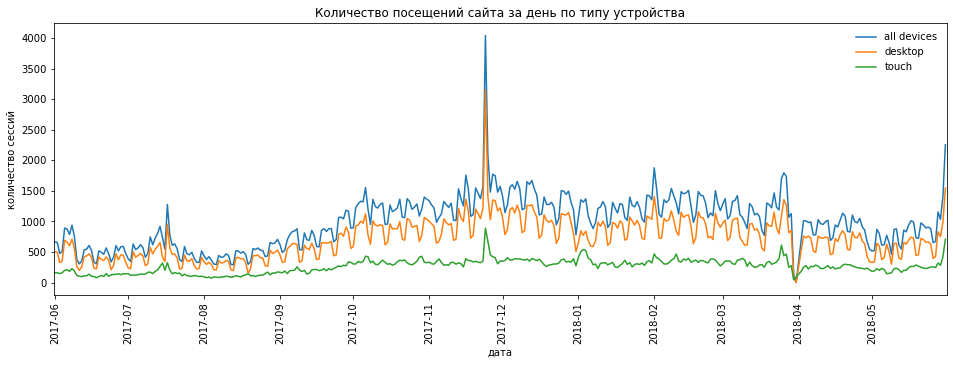

In [32]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set(title='Количество посещений сайта за день по типу устройства', xlabel='дата', ylabel='количество сессий')
device_plot(day_visits, device_day_visits, 'visit_date', 'uid')

In [33]:
print('Среднее количество посещений сайта в день для всех пользователей составляет {}, \
для пользователей стационарных устройств - {}, а для пользователей карманных устройств - {} сессий.'
.format(int(day_visits['uid'].median()), int(device_day_visits.query('device == "desktop"')['uid'].median()),
       int(device_day_visits.query('device == "touch"')['uid'].median())))

Среднее количество посещений сайта в день для всех пользователей составляет 1003, для пользователей стационарных устройств - 711, а для пользователей карманных устройств - 278 сессий.


Наблюдаем интересную тенденцию: количество сессий со стационарного устройства имеет очень близкую динамику со всеми сессиями. Скорее всего, это связано с тем, что пользователей на таких устройствах заходит больше - и это имеет больший вклад в динамику совокупного показателя. Количество сессий с карманного устройства имеет несколько иную динамику и меньше колебаний по ежедневным посещениям сайта.

Имеется заметный "всплеск" в конце ноября-начале декабря. Возможно, в этот момен было проведено несколько рекламных кампаний, либо одна, но очень эффективная. Также был небольшой "всплеск" в середине июля, начале февраля, ближе к концу марта, в конце мая. Однако, имеется и спад для всех устройств: в конце марта-начале апреля - сразу же после подъёма. Возможно, имелись какие-то технические неполадки с сайтом, и люди не могли на него "зайти". Если это произошло сразу после рекламной компании, это негативно отразилось на показателях привлечения по результатам кампании, так как могло снизить доверие пользователей к данному ресурсу и потерять тех, кто пришёл "по горячим следам". Учтём данную предпосылку при дальнейшем анализе.

Поскольку показатели подвержены значительным колебаниям, в качестве среднего значения сессий в день рассчитаем медиану.

In [34]:
day_visits_med = day_visits['uid'].median()
desktop_day_visits_med = device_day_visits.query('device == "desktop"')['uid'].median()
touch_day_visits_med = device_day_visits.query('device == "touch"')['uid'].median()
print('Среднее количество сессий в день на сайте Яндекс.Афиша составляет {:.0f} для всех устройств. \
Для стационарных устройств значение равно {:.0f}. Для карманных устройств - {:.0f} сессий.'
      .format(day_visits_med, desktop_day_visits_med, touch_day_visits_med))

Среднее количество сессий в день на сайте Яндекс.Афиша составляет 1003 для всех устройств. Для стационарных устройств значение равно 711. Для карманных устройств - 278 сессий.


Построим график ежедневной посещаемости сайта - в зависимости от рекламных источников, по которым "пришёл" клиент.

In [35]:
# Создадим функцию для построения графика динамики исследуемого показателя по типу рекламного источника
def source_plot(df_source, date_column, result_column):
    for source in df_source['source_id'].unique():
        (ax.plot(df_source.query('source_id == @source')[date_column], 
                 df_source.query('source_id == @source')[result_column], label=source))
    ax.grid=True
    xax = ax.xaxis
    xlabels = xax.get_ticklabels()
    for label in xlabels:
        label.set_rotation(90)
        label.set_fontsize(10)
    ax.legend(frameon=False)
    xax.zoom(0.443)
    plt.show()

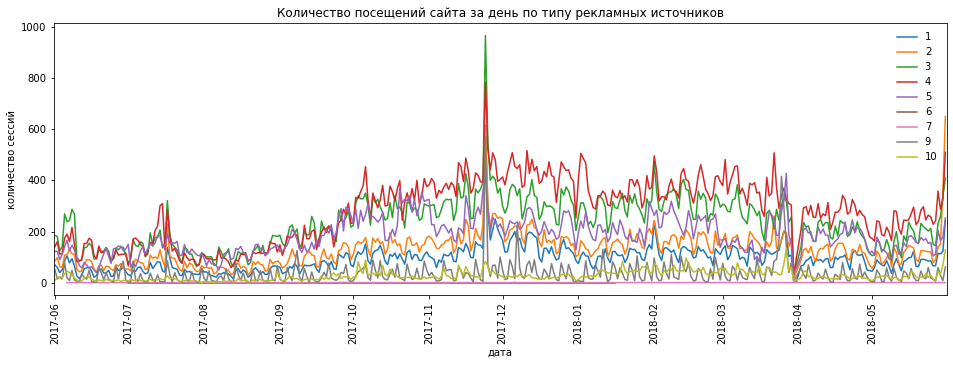

In [36]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set(title='Количество посещений сайта за день по типу рекламных источников', xlabel='дата', ylabel='количество сессий')
source_plot(source_day_visits, 'visit_date', 'uid')

Максимальное число пользователей посещало сайт на протяжении долгого периода из 3 источника, но затем его превзошло число пользователей из 4 рекламного источника. Как и при анализе числа пользователей "приверженных" продукту, эти источники характеризуются как наиболее эффективные. Также высокое значение показывают пользователи, пришедшие из рекламных источников под номерами 5, 2 и 1. Невысокие показатели для источника 10. И для 6 и 7 источников количество посещений близко к нулю. То есть, для них характерно не только низкое число пользователей (1-2), но и их пассивность в использовании сайта.

Построим график динамики ежедневных посещений сайта для пользователей, пришедших из различных источников рекламы, выполняющих вход на сайт со стационарного устройства.

In [37]:
# Создадим функцию для построения графика динамики исследуемого показателя по типу устройства и рекламного источника
def device_source_plot(df_device_source, device_type, date_column, result_column):
    for source in device_source_day_visits['source_id'].unique():
        (ax.plot(df_device_source.query('device == @device_type & source_id == @source')[date_column],
                 df_device_source.query('device == @device_type & source_id == @source')[result_column], label=source))
    ax.grid=True
    xax = ax.xaxis
    xlabels = xax.get_ticklabels()
    for label in xlabels:
        label.set_rotation(90)
        label.set_fontsize(10)
    ax.legend(frameon=False)
    xax.zoom(0.443)
    plt.show()

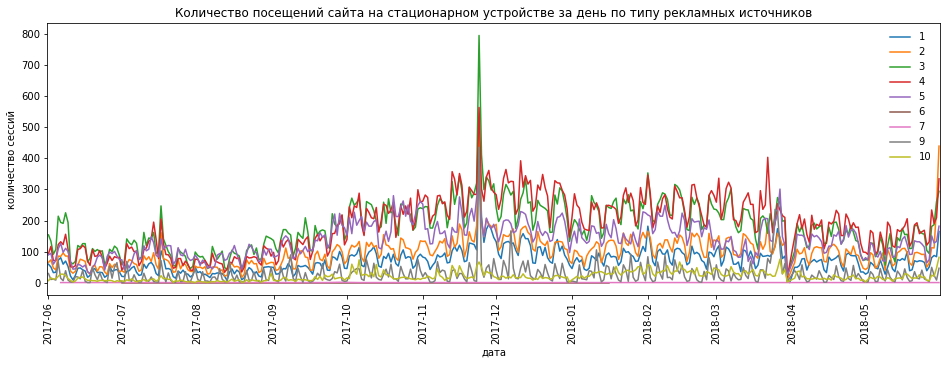

In [38]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set(title='Количество посещений сайта на стационарном устройстве за день по типу рекламных источников', 
       xlabel='дата', ylabel='количество сессий')
device_source_plot(device_source_day_visits, 'desktop', 'visit_date', 'uid')

Динамика посещений со стационарного устройства идентична динамике для всех устройств для каждого из рекламных источников. Но разрыв между источниками меньше, чем для совокупной выборки. Практически нет разрыва по количеству сессий для клиентов с третьего и четвёртого источников. Значит, увеличенный разрыв обусловлен наиболее сильным влиянием некоторых источников на пользователей, входящих на сайт с карманного устройства.

Построим график динамики ежедневных посещений сайта для пользователей, пришедших из различных источников рекламы, выполняющих вход на сайт с карманного устройства.

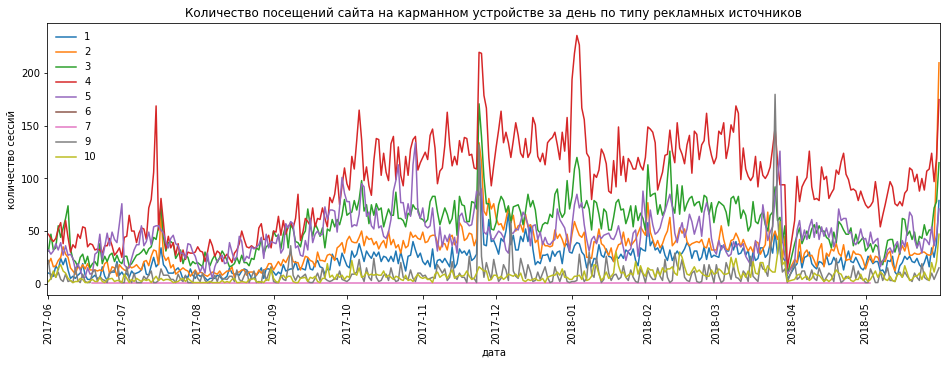

In [39]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set(title='Количество посещений сайта на карманном устройстве за день по типу рекламных источников', 
       xlabel='дата', ylabel='количество сессий')
device_source_plot(device_source_day_visits, 'touch', 'visit_date', 'uid')

Для карманных устройств существует явно выраженное преобладание посетителей, пришедших по четвёртому источнику рекламы. Этот отрыв выражен сильнее, чем в случае со стационарными устройствами.

Также на посещения с карманного устройства сильно повлиял пятый рекламный источник (чего не было для стационарного устройства) и третий источник (который был долгое время преобладающим для стационарного устройства).

*Количество сессий в день, приходящихся на одного пользователя*

Рассчитаем количество сессий на одного пользователя по каждому дню.

In [40]:
sess_per_user = visits.groupby('visit_date').agg({'uid': ['count', 'nunique']}).reset_index()
sess_per_user.columns = ['visit_date', 'n_sessions', 'n_users']
sess_per_user['sess_per_user'] = sess_per_user['n_sessions'] / sess_per_user['n_users']
sess_per_user

,visit_date,n_sessions,n_users,sess_per_user
0,2017-06-01,664,605,1.097521
1,2017-06-02,658,608,1.082237
2,2017-06-03,477,445,1.071910
3,2017-06-04,510,476,1.071429
4,2017-06-05,893,820,1.089024
...,...,...,...,...
359,2018-05-27,672,620,1.083871
360,2018-05-28,1156,1039,1.112608
361,2018-05-29,1035,948,1.091772
362,2018-05-30,1410,1289,1.093871


Аналогично рассчитаем количество сессий на одного пользователя по каждому дню для различных устройств, различных рекламных источников; и отобразим полученные метрики на графике.

In [41]:
# По типу устройств
device_sess_per_user = visits.groupby(['device', 'visit_date']).agg({'uid': ['count', 'nunique']}).reset_index()
device_sess_per_user.columns = ['device', 'visit_date', 'n_sessions', 'n_users']
device_sess_per_user['sess_per_user'] = device_sess_per_user['n_sessions'] / device_sess_per_user['n_users']

# По типу рекламного источника
source_sess_per_user = visits.groupby(['source_id', 'visit_date']).agg({'uid': ['count', 'nunique']}).reset_index()
source_sess_per_user.columns = ['source_id', 'visit_date', 'n_sessions', 'n_users']
source_sess_per_user['sess_per_user'] = source_sess_per_user['n_sessions'] / source_sess_per_user['n_users']

# По типу устройств и рекламного источника
device_source_sess_per_user = (visits.groupby(['device', 'source_id', 'visit_date'])
                               .agg({'uid': ['count', 'nunique']}).reset_index())
device_source_sess_per_user.columns = ['device', 'source_id', 'visit_date', 'n_sessions', 'n_users']
device_source_sess_per_user['sess_per_user'] = (device_source_sess_per_user['n_sessions'] / 
                                                device_source_sess_per_user['n_users'])

Построим график динамики количества сессий на одного пользователя для различных устройств.

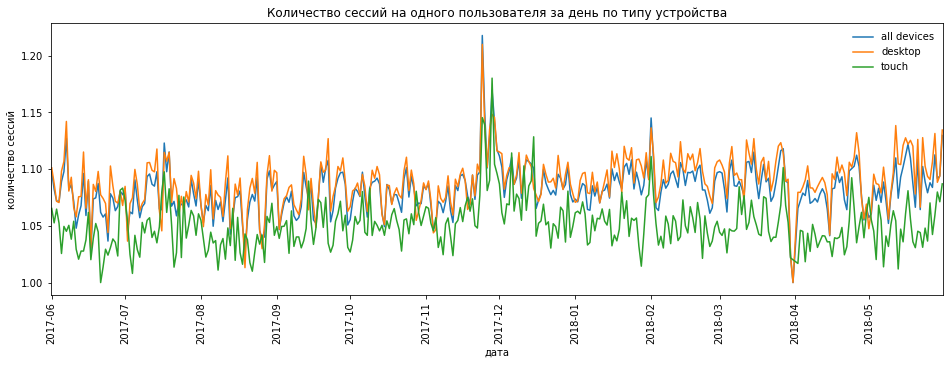

In [42]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set(title='Количество сессий на одного пользователя за день по типу устройства', xlabel='дата', ylabel='количество сессий')
device_plot(sess_per_user, device_sess_per_user, 'visit_date', 'sess_per_user')

In [43]:
print('Среднее количество посещений сайта в день, приходящихся на одного пользователя, в целом, составляет {:.2f}, \
для пользователей стационарных устройств - {:.2f}, и для пользователей карманных устройств - {:.2f} сессий.'
.format(int(sess_per_user['sess_per_user'].median()), 
        int(device_sess_per_user.query('device == "desktop"')['sess_per_user'].median()),
        int(device_sess_per_user.query('device == "touch"')['sess_per_user'].median())))

Среднее количество посещений сайта в день, приходящихся на одного пользователя, в целом, составляет 1.00, для пользователей стационарных устройств - 1.00, и для пользователей карманных устройств - 1.00 сессий.


Динамика количества сессий, приходящихся на одного пользователя, за день близка к динамике ежедневных сессий (мы видим такие же сильные всплески в те же даты, и такой же спад в начале апреля 2018). Тем не менее, в среднем посетители реже заходят с карманных устройств в день, чем со стационарных устройств. Хотя есть дни, в которые количество сессий со стационарных устройств было равно количеству сессий для одного пользователя с карманных устройств.

Построим график динамики количества сессий на одного пользователя в зависимости от источников рекламы.

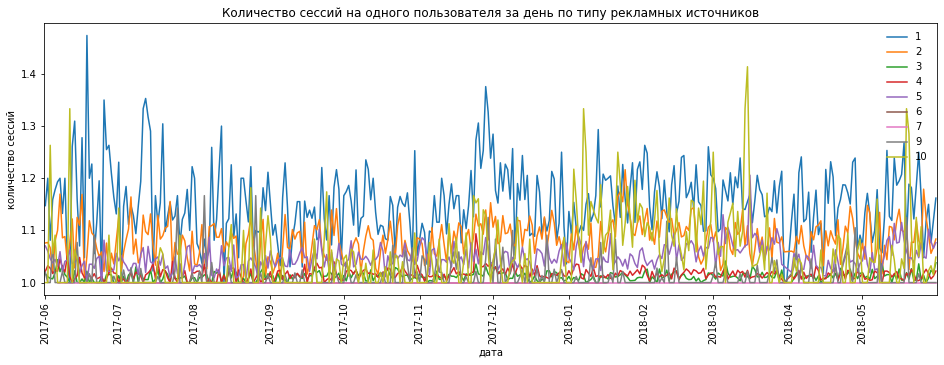

In [44]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set(title='Количество сессий на одного пользователя за день по типу рекламных источников', xlabel='дата', 
       ylabel='количество сессий')
source_plot(source_sess_per_user, 'visit_date', 'sess_per_user')

В основном пользователи заходят чуть более 1 раза в день. Но есть и исключения. Это пользователи, пришедшие с первого, второго, пятого и десятого источников. Из них лидирующим является первый источник: пользователи, пришедшие по нему неоднократно пользуются сайтом в течение дня. Также интересен десятый источник: по нему наблюдаются периодические всплески входа на сайт.

Построим график динамики ежедневных посещений, приходящихся на одного пользователя сайта, для различных источников рекламы, с условием, что пользователь выполняет вход на сайт со стационарного устройства.

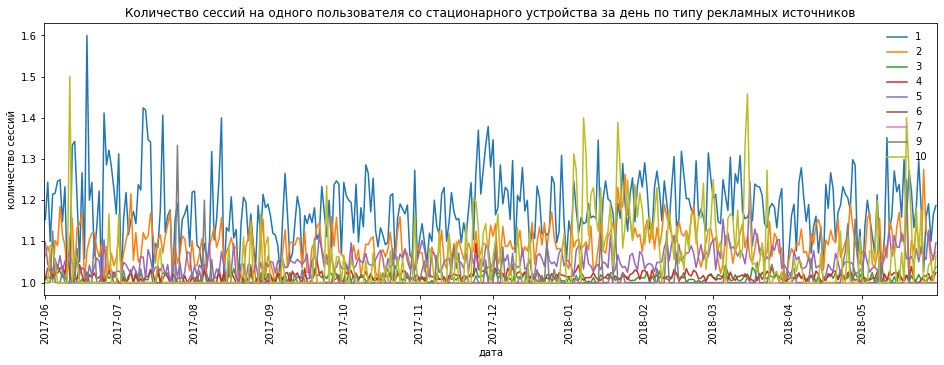

In [45]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set(title='Количество сессий на одного пользователя со стационарного устройства за день по типу рекламных источников', 
       xlabel='дата', ylabel='количество сессий')
device_source_plot(device_source_sess_per_user, 'desktop', 'visit_date', 'sess_per_user')

Динамика входа пользователей со стационарного устройства схожа с общей динамикой. Однако, следует отметить наиболее сильные "всплески" сессий на одного человека, пришедшего с десятого рекламного источника.

Построим график динамики ежедневных посещений, приходящихся на одного пользователя сайта, для различных источников рекламы, с условием, что пользователь выполняет вход на сайт с карманного устройства.

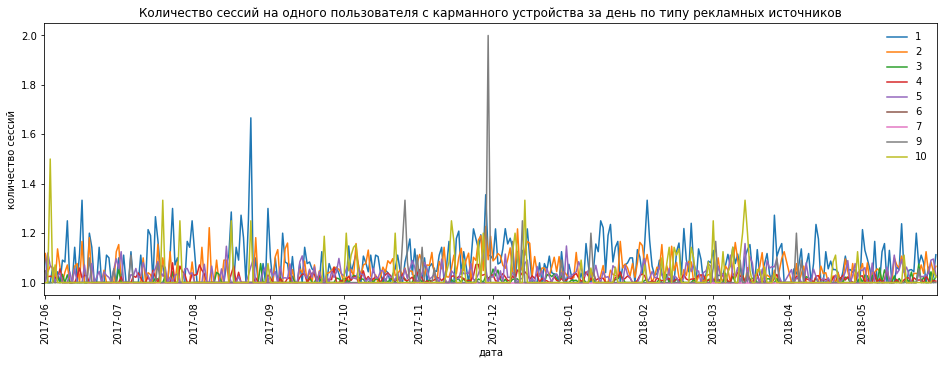

In [46]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set(title='Количество сессий на одного пользователя с карманного устройства за день по типу рекламных источников', 
       xlabel='дата', ylabel='количество сессий')
device_source_plot(device_source_sess_per_user, 'touch', 'visit_date', 'sess_per_user')

Любопытно, что с карманного устройства наблюдалось несколько входов пользователей (около 2 для каждого), пришедших по девятому источнику, в конце ноября-начале декабря 2017 года. Также всплеск по данному рекламному источнику наблюдался в конце октября 2017 года; и источник "срабатывал" периодически на протяжении всего рассматриваемого периода.

#### Длительность одной сессии

Рассчитаем продолжительность сессий и построим гистограмму.

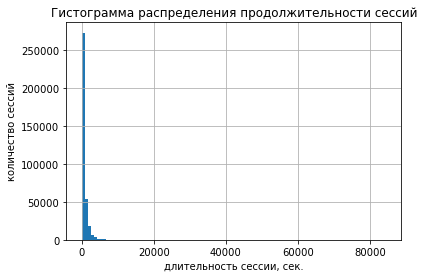

In [47]:
visits['sess_dur_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
fig, ax = plt.subplots()
ax.set(title='Гистограмма распределения продолжительности сессий', xlabel='длительность сессии, сек.', 
       ylabel='количество сессий')
visits['sess_dur_sec'].hist(bins=100);

На графике видим, что длина сессий распределена неравномерно. Это отразится на разнице между средним значением, модой и медианой. Рассчитаем эти показатели, рассмотрим разницу и назовём переменную, которая определит метрику ASL.

In [48]:
sess_dur_mean = visits['sess_dur_sec'].mean()
sess_dur_mode = visits['sess_dur_sec'].mode()
sess_dur_median = visits['sess_dur_sec'].median()
print('Среднее значение длительности одной сессии составило {} сек., модальное значение составило {} сек., а медиана \
- {} сек.'.format(int(sess_dur_mean), int(sess_dur_mode), int(sess_dur_median)))

Среднее значение длительности одной сессии составило 643 сек., модальное значение составило 60 сек., а медиана - 300 сек.


Поскольку распределение не является нормальным и не близко к нормальному, мы не можем использовать среднее и медиану для оценки среднего показателя длительности сессии. Показателем ASL, на динамику которого можно ориентироваться бизнесу в дальнейшем, будет мода, равная 60 секунд.

In [49]:
asl = sess_dur_mode

Также важно отметить, что у нас есть очень большое число сессий продолжительностью 0 секунд. То есть пользователи открыли и сразу же закрыли сайт. Это может быть связано со случайным "кликом", либо с проблемами в загрузке сайта (пользователь не дождался, когда сайт откроется и закрыл его). Мода также учитывает случайность такого являения, то есть это не влияет на результат метрики.

*ASL для различных типов устройств*

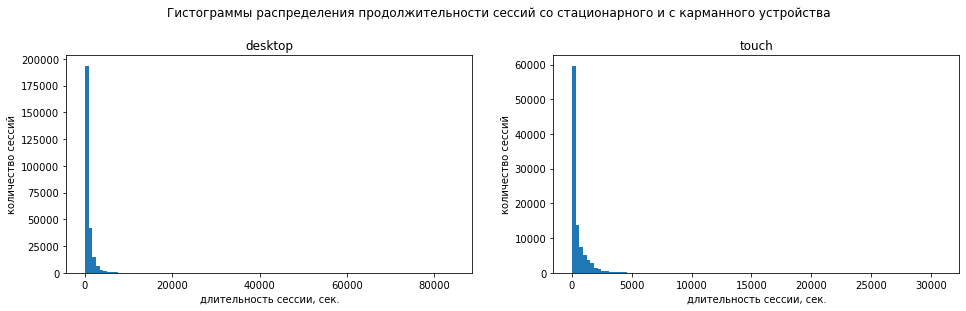

In [50]:
fig = plt.figure(figsize=(16,4))
fig.suptitle('Гистограммы распределения продолжительности сессий со стационарного и с карманного устройства', y = 1.05)
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)
ax_1.set(title='desktop', xlabel='длительность сессии, сек.', ylabel='количество сессий')
ax_2.set(title='touch', xlabel='длительность сессии, сек.', ylabel='количество сессий')
ax_1.hist(visits.query('device == "desktop"')['sess_dur_sec'], bins=100)
ax_2.hist(visits.query('device == "touch"')['sess_dur_sec'], bins=100)
plt.show()

Для каждого из устройств наблюдается схожее распределение параметра, поэтому срединной мерой для него будет являться мода.

In [51]:
asl_desktop = visits.query('device == "desktop"')['sess_dur_sec'].mode()
asl_touch = visits.query('device == "touch"')['sess_dur_sec'].mode()
print('ASL со стационарного устройства составила {} сек., и с карманного устройства - {} сек.'
      .format(int(asl_desktop), int(asl_touch)))

ASL со стационарного устройства составила 60 сек., и с карманного устройства - 60 сек.


Получается, что средняя длительность одной сессии идентична для любого типа устройства и составляет 60 секунд (1 минуту).

#### Retention Rate и Churn Rate

Для того, чтобы оценить, как часто люди возвращаются на сайт, необходимо рассчитать Retention Rate и Churn Rate. Для этого нам необходимо сформировать когорту, определив событие и период, на базе которых она будет создана. Возьмём дату, когда пользователь впервые зашёл на сайт Яндекс.Афиша.

In [52]:
# найдём для каждого пользователя первую дату входа на сайт и сохраним таблицу в Series
first_visit_date = visits.groupby('uid')['visit_date'].min()
first_visit_date.name = 'first_visit_date'

In [53]:
# Объединим полученный Series с исходным Dataframe-ом
visits = visits.join(first_visit_date, on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,visit_year,visit_month,visit_week,visit_date,sess_dur_sec,first_visit_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27


Поскольку, судя по предшествующему анализу, у нас имеется, как правило, один всплеск или резкое падение посещений в течение месяца, мы можем проводить когортный анализ по месяцу. Деление когорт на недели или дни, на наш взгляд, не имеет смысла.

In [54]:
# Получим первое число месяца, в котором произошло событие
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits['activity_month'] = visits['visit_date'].astype('datetime64[M]')

# Рассчитаем lifetime пользователя в рамках когорты
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

# Рассчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»
cohorts = visits.pivot_table(index='first_visit_month',
                            columns='cohort_lifetime',
                            values='uid',
                            aggfunc='nunique')
cohorts.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,13259.0,1043,713,814,909,947,809,766,694,674,539,596
2017-07-01,13140.0,737,674,738,765,633,596,601,510,376,361,
2017-08-01,10181.0,783,640,639,510,448,370,402,284,265,,
2017-09-01,16704.0,1428,1156,847,658,632,599,404,381,,,
2017-10-01,25977.0,2042,1357,1012,890,837,555,529,,,,
2017-11-01,27248.0,2133,1202,1054,919,638,594,,,,,
2017-12-01,25268.0,1410,960,786,512,481,,,,,,
2018-01-01,22624.0,1351,890,565,458,,,,,,,
2018-02-01,22197.0,1267,565,446,,,,,,,,


*Retention Rate*

Рассчитаем Retention Rate по полученным когортам и отобразим метрику на тепловой карте.

In [55]:
retention = pd.DataFrame()
for column in cohorts.columns:
    retention = pd.concat([retention, (cohorts[column]/cohorts[0])], axis=1)
retention.columns = cohorts.columns

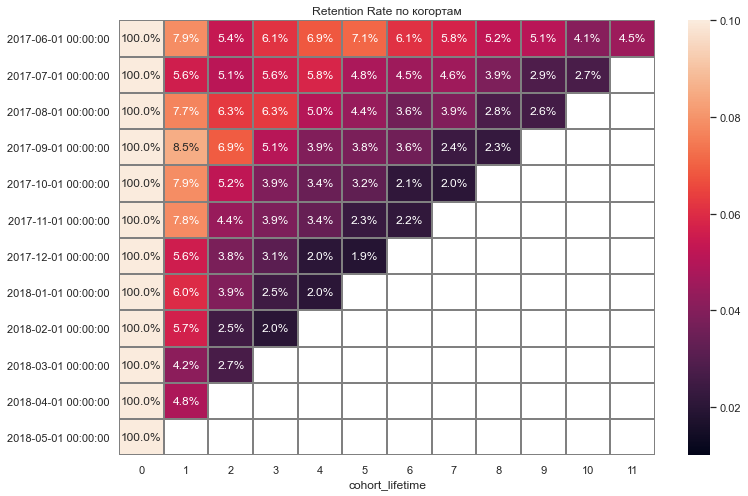

In [56]:
retention.fillna('')
sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Retention Rate по когортам')
sns.heatmap(retention, annot=True, fmt='.1%', vmin=0.01, vmax=0.1, linewidths=1, linecolor='gray');

In [57]:
print('В среднем около {:.1%} пользователей возвращается на сайт на следующий месяц после первого посещения.'
      .format(retention[1].mean()))

В среднем около 6.5% пользователей возвращается на сайт на следующий месяц после первого посещения.


Показатель возврата пользователей к продукту очень низок: менее 10% в каждый из месяцев, следующих за первым посещением.

В августе 2017 года наблюдалось снижение пользовательской активности. Это может быть связано с какими-то иными факторами, не имеющими отношение к приверженности пользователей. В сентябре наблюдался рост показателей для июньской и августовской когорт; но пользователи из июльской когорты сократили посещение. В октябре видим рост по всем когортам, кроме августовской. Так, по всем когортам наблюдается спад активности на второй месяц использования сайта, что должно быть учтено в маркетинговой компании Яндекс.Афиши. 

Самыми активными пользователями на следующий месяц после первого посещения были сентябрьские пользователи, а самыми неактивными - пользователи, впервые зашедшие в марте и апреле 2018 года.

Рассчитаем аналогичные показатели для стационарных устройств и для карманных устройств.

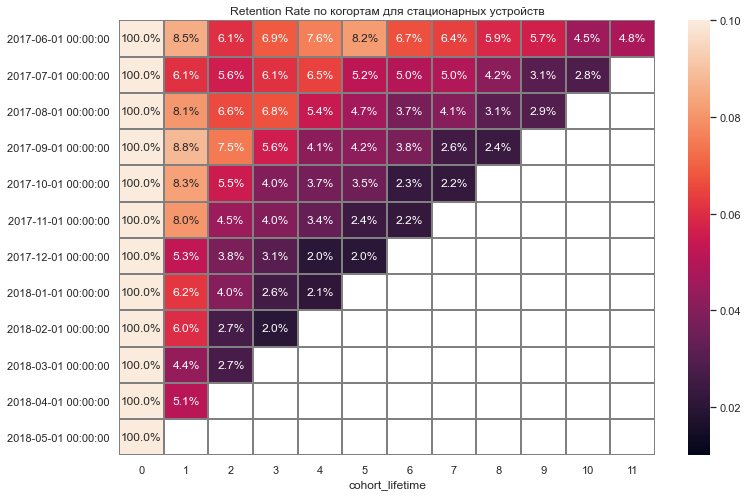

In [58]:
cohorts_desktop = (visits
                   .query('device == "desktop"')
                   .pivot_table(index='first_visit_month',
                                columns='cohort_lifetime',
                                values='uid',
                                aggfunc='nunique'))
cohorts_desktop.fillna('')

retention_desktop = pd.DataFrame()
for column in cohorts_desktop.columns:
    retention_desktop = pd.concat([retention_desktop, (cohorts_desktop[column]/cohorts_desktop[0])], axis=1)
retention_desktop.columns = cohorts_desktop.columns
retention_desktop.fillna('')

sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Retention Rate по когортам для стационарных устройств')
sns.heatmap(retention_desktop, annot=True, fmt='.1%', vmin=0.01, vmax=0.1, linewidths=1, linecolor='gray');

Для пользователей, которые посещают сайт со стационарных устройств, сложно выделить когорту, которая была самой активной на следующий месяц после первого посещения. В целом, все пользователи были относительно активны. Но самыми неактивными были пользователи, впервые зашедшие в марте 2018 года.

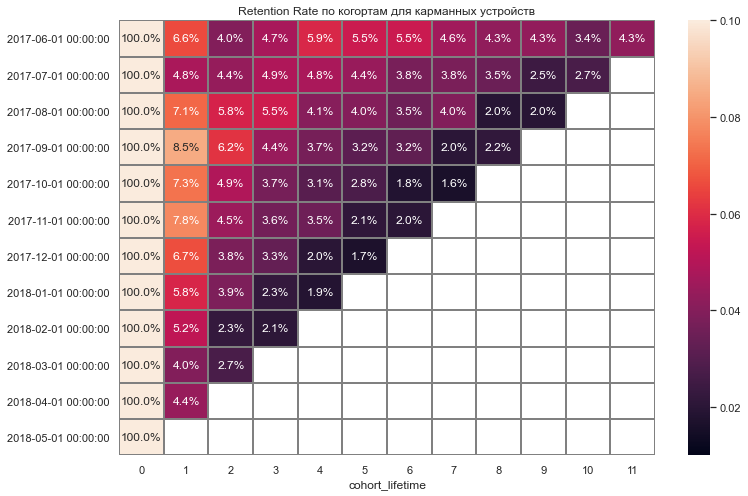

In [59]:
cohorts_touch = (visits
                   .query('device == "touch"')
                   .pivot_table(index='first_visit_month',
                                columns='cohort_lifetime',
                                values='uid',
                                aggfunc='nunique'))
cohorts_touch.fillna('')

retention_touch = pd.DataFrame()
for column in cohorts_touch.columns:
    retention_touch = pd.concat([retention_touch, (cohorts_touch[column]/cohorts_touch[0])], axis=1)
retention_touch.columns = cohorts_touch.columns
retention_touch.fillna('')

sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Retention Rate по когортам для карманных устройств')
sns.heatmap(retention_touch, annot=True, fmt='.1%', vmin=0.01, vmax=0.1, linewidths=1, linecolor='gray');

In [60]:
print('В среднем около {:.1%} пользователей стационарных устройств и около {:.1%} пользователей \
карманных устройств возвращается на сайт на следующий месяц после первого посещения.'
      .format(retention_desktop[1].mean(), retention_touch[1].mean()))

В среднем около 6.8% пользователей стационарных устройств и около 6.2% пользователей карманных устройств возвращается на сайт на следующий месяц после первого посещения.


Активность пользователей, заходящих на сайт с карманных устройств, была ниже, чем использующих стационарные устройства. Самыми неактивными в последующие месяцы оказались пользователи, посетившие сайт в марте и апреле 2018 года и в июле 2017 года.

*Churn Rate*

Рассчитаем Churn Rate по полученным когортам и отобразим метрику на тепловой карте.

In [61]:
churn = pd.DataFrame()
churn[0] = 0
for column in range(1, 12):
    churn = pd.concat([churn, ((cohorts[column] - cohorts[column-1])/cohorts[column-1])], axis=1)
churn.columns = cohorts.columns
churn[0] = churn[0].fillna(0)
churn.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
2017-06-01 00:00:00,0.0,-0.921336,-0.316395,0.141655,0.116708,0.0418042,-0.145723,-0.053152,-0.0939948,-0.0288184,-0.200297,0.105751
2017-07-01 00:00:00,0.0,-0.943912,-0.0854817,0.0949555,0.0365854,-0.172549,-0.0584518,0.00838926,-0.151414,-0.262745,-0.0398936,
2017-08-01 00:00:00,0.0,-0.923092,-0.182631,-0.0015625,-0.201878,-0.121569,-0.174107,0.0864865,-0.293532,-0.0669014,,
2017-09-01 00:00:00,0.0,-0.914511,-0.190476,-0.267301,-0.22314,-0.0395137,-0.0522152,-0.325543,-0.0569307,,,
2017-10-01 00:00:00,0.0,-0.921392,-0.335455,-0.254237,-0.120553,-0.0595506,-0.336918,-0.0468468,,,,
2017-11-01 00:00:00,0.0,-0.921719,-0.436474,-0.123128,-0.128083,-0.305767,-0.0689655,,,,,
2017-12-01 00:00:00,0.0,-0.944198,-0.319149,-0.18125,-0.348601,-0.0605469,,,,,,
2018-01-01 00:00:00,0.0,-0.940285,-0.341229,-0.365169,-0.189381,,,,,,,
2018-02-01 00:00:00,0.0,-0.94292,-0.554065,-0.210619,,,,,,,,
2018-03-01 00:00:00,0.0,-0.958182,-0.353078,,,,,,,,,


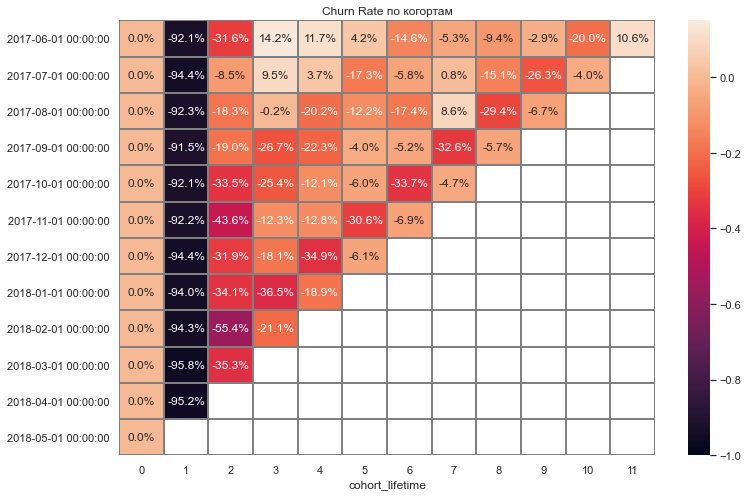

In [62]:
sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Churn Rate по когортам')
sns.heatmap(churn, annot=True, fmt='.1%', vmin=-1, vmax=0.15, linewidths=1, linecolor='gray');

In [63]:
print('В среднем около {:.1%} пользователей перестаёт заходить на сайт на следующий месяц после первого посещения.'
      .format(-churn[1].mean()))

В среднем около 93.5% пользователей перестаёт заходить на сайт на следующий месяц после первого посещения.


В целом, наблюдается достаточно интересная, но негативная картина. В первый же месяц за месяцем первого входа на сайт наблюдается отток около 95% пользователей. Но в дальнейшем пользователи уходят с меньшей интенсивностью. 

В некоторые месяцы даже наблюдался прирост пользователей, то есть о платформе вспомнили пользователи, которые на неё давно не заходили. Возможно, это было как раз связано с рекламными кампаниями.

Апрель 2018 года характерен очень большим количеством ушедших пользователей. Как мы видели ранее, это могло быть связано с какими-то техническими работами или проблемами, когда посещений сайта не было. Подобное событие могло отпугнуть пользователей.

Рассчитаем аналогичные показатели для стационарных устройств и для карманных устройств.

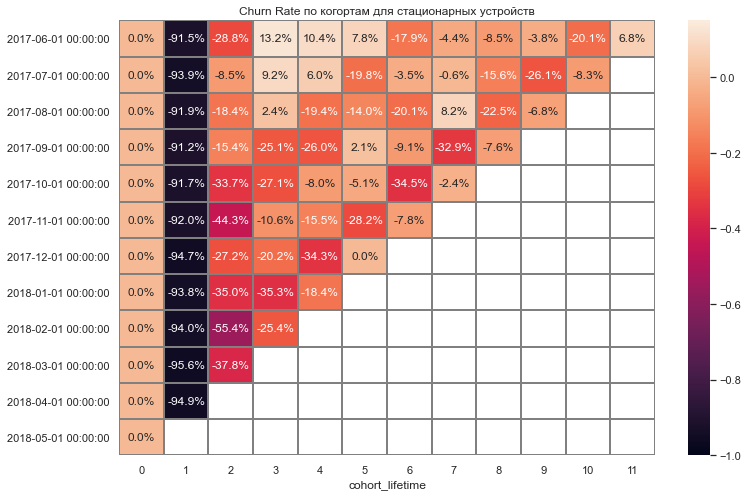

In [64]:
churn_desktop = pd.DataFrame()
churn_desktop[0] = 0
for column in range(1, 12):
    churn_desktop = pd.concat([churn_desktop, ((cohorts_desktop[column] - cohorts_desktop[column-1])/
                                               cohorts_desktop[column-1])], axis=1)
churn_desktop.columns = cohorts_desktop.columns
churn_desktop[0] = churn_desktop[0].fillna(0)
churn_desktop.fillna('')

sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Churn Rate по когортам для стационарных устройств')
sns.heatmap(churn_desktop, annot=True, fmt='.1%', vmin=-1, vmax=0.15, linewidths=1, linecolor='gray');

Для пользователей на стационарных устройствах наблюдается схожая динамика, что и для всех пользователей.

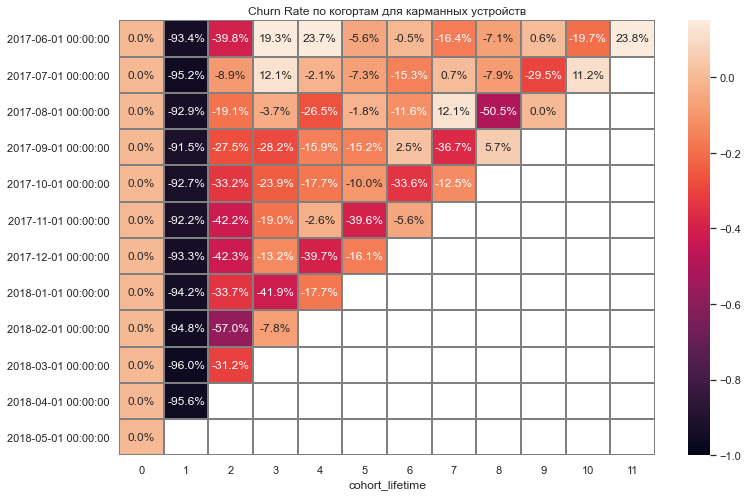

In [65]:
churn_touch = pd.DataFrame()
churn_touch[0] = 0
for column in range(1, 12):
    churn_touch = pd.concat([churn_touch, ((cohorts_touch[column] - cohorts_touch[column-1])/
                                               cohorts_touch[column-1])], axis=1)
churn_touch.columns = cohorts_touch.columns
churn_touch[0] = churn_touch[0].fillna(0)
churn_touch.fillna('')

sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Churn Rate по когортам для карманных устройств')
sns.heatmap(churn_touch, annot=True, fmt='.1%', vmin=-1, vmax=0.15, linewidths=1, linecolor='gray');

In [66]:
print('В среднем около {:.1%} пользователей стационарных устройств и около {:.1%} пользователей \
карманных устройств перестают заходить на сайт на следующий месяц после первого посещения.'
      .format(-churn_desktop[1].mean(), -churn_touch[1].mean()))

В среднем около 93.2% пользователей стационарных устройств и около 93.8% пользователей карманных устройств перестают заходить на сайт на следующий месяц после первого посещения.


Для пользователей карманных устройств наблюдаем следующие особенности. Отток пользователей в апреле 2018 года был намного сильнее, чем отток пользователей стационарных устройств. Скорее всего, это связано с порядком чисел (поскольку пользователей стационарных устройств на порядок больше, их изменение будет относительно небольшим к большой выборке; а для пользователей карманных устройств даже незначительное изменение будет относительно больше из-за небольших величин предыдущего периода). 

Соответственно, мы должны учитывать, что пользователи карманных устройств более чувствительны к любым изменениям сайта (положительным и отрицательным), чем пользователи стационарных устройств.

### Вывод по продуктовым метрикам <a id='step_3.2'></a>

За период с июня 2017 по конец мая 2018 года получили следующие продуктовые метрики. Число посещений сайта составило: **DAU (в день)** = 907 для всех пользователей, 252 для пользователей с touch device, 659 для пользователей с desktop device; **WAU (в неделю)** = 5716 для всех пользователей, 1634 для пользователей с touch device, 4129 для пользователей с desktop device; **MAU (в месяц)** = 23228 для всех пользователей, 6825 для пользователей с touch device, 16724 для пользователей с desktop device. **Sticky factor по отношению к недельной аудитории** = 15,88%. **Sticky factor по отношению к месячной аудитории** = 3,91%. Показатели вовлечённости пользователей (sticky factor) практически равны на разных устройствах и близки к значению по всей выборке, однако на стационарных устройствах они незначительно выше, чем на карманных как для недельной аудитории, так и для месячной аудитории.

**Среднее количество посещений сайта в день** для всех пользователей составляет 1003, для пользователей desktop device - 711, а для пользователей touch device - 278 сессий. **Среднее количество посещений сайта в день, приходящихся на одного пользователя**, составляет 1 сессию, вне зависимости от того, с какого устройства входит пользователь. Однако, разница проявлялась в динамике.

**Средняя длительность одной сессии (ASL)** составила 60 сек., вне зависимости от того, с какого устройства выполняет вход пользователь.

**Показатель Retention Rate** составил 6,5% для всех пользователей; 6,8% для пользователей стационарных устройств; 6,2% для пользователей карманных устройств. Это значит, что в среднем около 6,5% пользователей возвращается на сайт на следующий месяц после первого посещения (6,8% и 6,2% для соответствующего типа устройства).

**Показатель Churn Rate** составил 93,5% для всех пользователей; 93,2% для пользователей стационарных устройств; 93,8% для пользователей карманных устройств. Это значит, что в среднем около 93,5% пользователей прекращает использование сайта на следующий месяц после первого посещения (93,2% и 93,8% для соответствующего типа устройства).

Заметим, что сумма посещений с карманных и стационарных устройств не равна соответствующим метрикам по всей выборке. Это говорит о том, что некоторые пользователи заходят на сайт и с карманного устройства, и со стационарного устройства.

При анализе посещений в разрезе рекламных источников было выявлено, что больше всего пользователей было привлечено на сайт *4 рекламным источником* (275 в день, 1829 в неделю и 7765 в месяц). На втором месте находится *3 источник рекламы* (132 пользователя в день, 1565 в неделю и 6758 в месяц). Далее идут *5 и 2 источники*. После них - *1, 9 и 10*. На разных типах устройств имеется ранжирование по типам рекламных источников, схожее с совокупной выборкой. Исходя из этого, можем предположить, что действие рекламы не влияет на приверженность потребителя к тому или иному источнику, с которого он будет открывать сайт. Однако, наибольшая "приверженность" пользователей сайту наблюдается для тех, кто пришёл со *2 и 1 источников*, и заходит со стационарных устройств: это характерно и для недельной аудитории, и для показателя за месяц.

"Выбиваются" по показателям *6 и 7 рекламные источники*: у нас имеется по одному пользователю для каждого из них (показатели идентичны для дня и недели). Тот же пользователь заходил на сайт в течение месяца (его вовлечённость равна 100%). Однако, по *7 источнику* был привлечён еще один пользователь в течение месяца. При этом оба пользователя, которые были привлечены *6 и 7 рекламным источником*, заходят на сайт с обоих типов устройств. Однако, пользователь, пришедший в течение месяца с *7 рекламного источника*, заходил только со стационарного устройства.

Также наблюдаем интересную тенденцию: количество сессий со стационарного устройства имеет очень близкую динамику со всеми сессиями. Скорее всего, это связано с тем, что пользователей на таких устройствах заходит больше - и это имеет больший вклад в динамику совокупного показателя. Количество сессий с карманного устройства имеет несколько иную динамику и меньше колебаний по ежедневным посещениям сайта. Имеется заметный "всплеск" в конце ноября-начале декабря. Возможно, в этот момен было проведено несколько рекламных кампаний, либо одна, но очень эффективная. Также был небольшой "всплеск" в середине июля, начале февраля, ближе к концу марта, в конце мая. Однако, имеется и спад для всех устройств: в конце марта-начале апреля - сразу же после подъёма. Возможно, имелись какие-то технические неполадки с сайтом, и люди не могли на него "зайти". Если это произошло сразу после рекламной компании, это негативно отразилось на показателях привлечения по результатам кампании, так как могло снизить доверие пользователей к данному ресурсу и потерять тех, кто пришёл "по горячим следам". Учтём данную предпосылку при дальнейшем анализе.

Максимальное число пользователей посещало сайт на протяжении долгого периода из *3 источника*, но затем его превзошло число пользователей из *4 рекламного источника*. Как и при анализе числа пользователей "приверженных" продукту, эти источники характеризуются как наиболее эффективные. Также высокое значение показывают пользователи, пришедшие из *рекламных источников* под номерами *5, 2 и 1*. Невысокие показатели для *источника 10*. И для *6 и 7 источников* количество посещений близко к нулю. То есть, для них характерно не только низкое число пользователей (1-2), но и их пассивность в использовании сайта. Динамика посещений со стационарного устройства идентична динамике для всех устройств для каждого из рекламных источников. Но разрыв между источниками меньше, чем для совокупной выборки. Практически нет разрыва по количеству сессий для клиентов с *3о и 4 источников*. Значит, увеличенный разрыв обусловлен наиболее сильным влиянием некоторых источников на пользователей, входящих на сайт с карманного устройства.

Для карманных устройств существует явно выраженное преобладание посетителей, пришедших по *4 источнику рекламы*. Этот отрыв выражен сильнее, чем в случае со стационарными устройствами. Также на посещения с карманного устройства сильно повлиял *5 рекламный источник* (что не было актуально для стационарного устройства) и *3 источник* (который был долгое время преобладающим для стационарного устройства).

Динамика количества сессий, приходящихся на одного пользователя, за день близка к динамике ежедневных сессий (мы видим такие же сильные всплески в те же даты, и такой же спад в начале апреля 2018). Тем не менее, в среднем посетители реже заходят с карманных устройств в день, чем со стационарных устройств. Хотя есть дни, в которые количество сессий со стационарных устройств было равно количеству сессий для одного пользователя с карманных устройств. В основном, пользователи заходят чуть более 1 раза в день. Но есть и исключения. Это пользователи, пришедшие с *1, 2, 5 и 10 источников*. Из них лидирующим является *1 источник*: пользователи, пришедшие по нему неоднократно пользуются сайтом в течение дня. Также интересен *10 источник*: по нему наблюдаются периодические всплески входа на сайт. Динамика входа пользователей со стационарного устройства схожа с общей динамикой. Однако, следует отметить наиболее сильные "всплески" сессий на одного человека, пришедшего с *10 рекламного источника*. Любопытно, что с карманного устройства наблюдалось несколько входов пользователей (около 2 для каждого), пришедших по *9 источнику*, в конце ноября-начале декабря 2017 года. Также всплеск по данному рекламному источнику наблюдался в конце октября 2017 года; и источник "срабатывал" периодически на протяжении всего рассматриваемого периода.

Кроме того, было выявлено, что имеется очень большое число сессий продолжительностью 0 секунд. То есть пользователи открыли и сразу же закрыли сайт. Это может быть связано со случайным "кликом", либо с проблемами в загрузке сайта (пользователь не дождался, когда сайт откроется и закрыл его). Мода также учитывает случайность такого являения, то есть это не влияет на результат метрики.

При анализе лояльности клиента сайту было выявлено, что в августе 2017 года наблюдалось снижение пользовательской активности. Это может быть связано с какими-то иными факторами, не имеющими отношение к приверженности пользователей. В сентябре наблюдался рост показателей для июньской и августовской когорт; но пользователи из июльской когорты сократили посещение. В октябре видим рост по всем когортам, кроме августовской. Так, по всем когортам наблюдается спад активности на второй месяц использования сайта, что должно быть учтено в маркетинговой компании Яндекс.Афиши. Самыми активными пользователями на следующий месяц после первого посещения были сентябрьские пользователи, а самыми неактивными - пользователи, впервые зашедшие в марте и апреле 2018 года. Для пользователей, которые посещают сайт со стационарных устройств, сложно выделить когорту, которая была самой активной на следующий месяц после первого посещения. В целом, все пользователи были относительно активны. Но самыми неактивными были пользователи, впервые зашедшие в марте 2018 года. Активность пользователей, заходящих на сайт с карманных устройств, была ниже, чем использующих стационарные устройства. Самыми неактивными в последующие месяцы оказались пользователи, посетившие сайт в марте и апреле 2018 года и в июле 2017 года.

В некоторые месяцы даже наблюдался прирост пользователей, то есть о платформе вспомнили пользователи, которые на неё давно не заходили. Возможно, это было как раз связано с рекламными кампаниями. Апрель 2018 года характерен очень большим количеством ушедших пользователей. Как мы видели ранее, это могло быть связано с какими-то техническими работами или проблемами, когда посещений сайта не было. Подобное событие могло отпугнуть пользователей. При этом для пользователей на стационарных устройствах наблюдается схожая динамика, что и для всех пользователей. Для пользователей карманных устройств наблюдаем следующие особенности. Отток пользователей в апреле 2018 года был намного сильнее, чем отток пользователей стационарных устройств. Скорее всего, это связано с порядком чисел (поскольку пользователей стационарных устройств на порядок больше, их изменение будет относительно небольшим к большой выборке; а для пользователей карманных устройств даже незначительное изменение будет относительно больше из-за небольших величин предыдущего периода).

Соответственно, мы должны учитывать, что пользователи карманных устройств более чувствительны к любым изменениям сайта (положительным и отрицательным), чем пользователи стационарных устройств.

### 2. Торговые метрики <a id='step_3.3'></a>

#### Период, с которого люди начинают покупать

Прежде чем вычислять период, в который пользователи начинают делать покупку, вычислим для каждого пользователя в таблице `orders` дату его первой покупки - аналогично тому, как мы рассчитывали дату первого посещения сайта в таблице `visits`.

In [67]:
# найдём для каждого пользователя первую дату покупки и сохраним таблицу в Series
orders['buy_date'] = orders['buy_ts'].dt.date
first_buy_date = orders.groupby('uid')['buy_date'].min()
first_buy_date.name = 'first_buy_date'
# Объединим полученный Series с исходным Dataframe-ом
orders = orders.join(first_buy_date, on='uid')

У нас есть ранее созданный объект Series с датой первого входа на сайт `first_visit_date` для каждого пользователя. Присоединим его к таблице `orders`.

In [68]:
orders = orders.join(first_visit_date, on='uid')

Для определения периода, с которого люди начинают покупать, создадим столбец, в котором приведена разница между датой первой покупки и датой первого входа на сайт.

In [69]:
orders['buy_visit_days'] = orders['first_buy_date'] - orders['first_visit_date']
orders.head()

,buy_ts,revenue,uid,buy_date,first_buy_date,first_visit_date,buy_visit_days
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0 days
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0 days
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0 days
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0 days
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0 days


Преобразуем тип < timedelta > в новом столбце в число дней, прошедших между датами.

In [70]:
orders['buy_visit_days'] = orders['buy_visit_days'] / np.timedelta64(1,'D')
orders.head()

,buy_ts,revenue,uid,buy_date,first_buy_date,first_visit_date,buy_visit_days
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0.0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0.0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0.0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0.0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0.0


Рассчитаем количество дней между первым входом на сайт и покупкой в среднем; а также рассморим, как распределена данная величина.

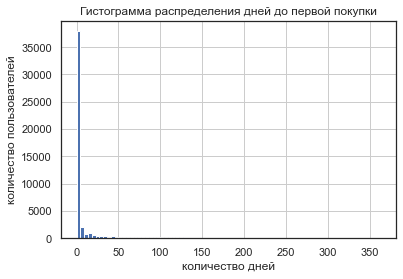

In [71]:
fig, ax = plt.subplots()
ax.set(title='Гистограмма распределения дней до первой покупки', xlabel='количество дней', 
       ylabel='количество пользователей')
orders['buy_visit_days'].hist(bins=80);

In [72]:
print('В среднем между покупкой и первым входом пользователя на сайт проходит {} дней.'
      .format(int(orders['buy_visit_days'].mode())))

В среднем между покупкой и первым входом пользователя на сайт проходит 0 дней.


In [73]:
orders['buy_visit_days'].describe()

count    50415.000000
mean        17.611227
std         46.469172
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max        363.000000
Name: buy_visit_days, dtype: float64

Достаточно большое число пользователей совершает покупку в тот же день, что и входит на сайт. Есть и те, кто покупает на несколько дней позже, и даже практически через год после первого входа (363 дня). Однако, общие закономерности показывают, что пользователи входят на сайт с целью совершения покупки; соответственно, главным в рекламной кампании должно быть привлечение клиента к сайту.

Рассмотрим, влияет ли тип устройства и тип рекламного источника на готовность пользователя сразу после входа на сайт сделать покупку. Для этого создадим новую таблицу, в которой отобразим пользователя, тип устройства, с которого он совершал первый вход, тип рекламного источника и момент покупки.

In [74]:
visit_buy = visits.merge(orders, on=['uid', 'first_visit_date'], how='left')
visit_buy = visit_buy[['device', 'source_id', 'uid', 'first_visit_date', 'buy_visit_days', 'sess_dur_sec']]
visit_buy.head()

,device,source_id,uid,first_visit_date,buy_visit_days,sess_dur_sec
0,touch,4,16879256277535980062,2017-12-20,NaN,1080
1,desktop,2,104060357244891740,2018-02-19,NaN,1680
2,touch,5,7459035603376831527,2017-07-01,NaN,0
3,desktop,9,16174680259334210214,2018-03-09,0.0,1440
4,desktop,3,9969694820036681168,2017-12-27,NaN,0


Видим, что есть пользователи, которые, хоть и заходили на сайт, не совершили покупок. Однако, среди них есть те, кто либо случайно зашёл на сайт, либо имел проблемы с его загрузкой и моментально вышел (длительность сессии 0 секунд). Посчитаем количество таких значений и уберём их.

In [75]:
len(visit_buy[(visit_buy['sess_dur_sec'] == 0) & (visit_buy['buy_visit_days'].isnull() == True)]['uid'].unique())

28555

Получили 28 555 пользователей, случайно заходивших на сайт.

In [76]:
visit_buy = visit_buy[(visit_buy['sess_dur_sec'] != 0) & (visit_buy['buy_visit_days'].isnull() != True)]

In [77]:
visit_buy['buy_visit_days'].isnull().sum()

0

Отметим, что именно случайно вошедшие на сайт пользователи не совершали покупок. В оставшейся выборке нет пустых значений.

*Период до покупки по типу устройства*

In [78]:
heading_table = ['device', 'avg_buy_days']
device_buy_metr = pd.DataFrame([], columns=heading_table)
device_buy_metr['device'] = visit_buy['device'].sort_values().unique()
for device in device_buy_metr['device']:
    device_buy_metr.loc[device_buy_metr['device'] == device, 'avg_buy_days'] = (
            int(visit_buy.loc[visit_buy['device'] == device, 'buy_visit_days'].mode()))
device_buy_metr

,device,avg_buy_days
0,desktop,0
1,touch,0


В среднем, большинство пользователей совершает покупку моментально, вне зависимости от типа устройства. Построим боксплоты по количеству дней, необходимых пользователям для совершения покупки с разбивкой по устройствам.

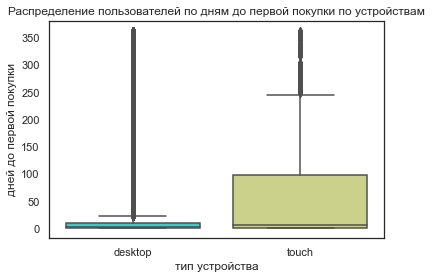

In [79]:
plt.title('Распределение пользователей по дням до первой покупки по устройствам')
plot = sns.boxplot(x='device', y='buy_visit_days', data=visit_buy, palette='rainbow')
plt.xlabel('тип устройства')
plt.ylabel('дней до первой покупки');

Наблюдаем явное преобладание требуемого количества дней до первой покупки для пользователей карманных устройств: боксплот более широкий. Изучим наиболее часто встречающиеся величины, исключив из визуализации выбивающиеся значения.

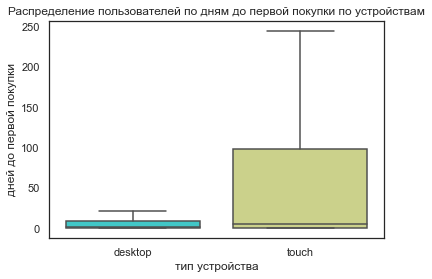

In [80]:
plt.title('Распределение пользователей по дням до первой покупки по устройствам')
plot = sns.boxplot(x='device', y='buy_visit_days', data=visit_buy, palette='rainbow', showfliers=False)
plt.xlabel('тип устройства')
plt.ylabel('дней до первой покупки');

Пользователям карманных устройств требуется значительно больше времени, чтобы совершить покупку после первого посещения (для 75% пользователей устройств это период до 100 дней). Пользователи стационарных устройств совершают покупку в течение нескольких дней. Это может быть связано с неудобством совершения покупки с мобильной версии сайта. Таким образом, пользователи могут отложить покупку и совершить её со стационарного устройства. Однако, часть их пользователей может уйти в этом процессе, либо забыть о покупке.

*Период до покупки по рекламному источнику*

In [81]:
heading_table = ['source', 'avg_buy_days']
source_buy_metr = pd.DataFrame([], columns=heading_table)
source_buy_metr['source'] = visit_buy['source_id'].sort_values().unique()
for source in source_buy_metr['source']:
    source_buy_metr.loc[source_buy_metr['source'] == source, 'avg_buy_days'] = (
            int(visit_buy.loc[visit_buy['source_id'] == source, 'buy_visit_days'].mode()))
source_buy_metr.sort_values(by='avg_buy_days')

,source,avg_buy_days
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,7,0
6,9,0
7,10,0


В среднем, большинство пользователей совершает покупку моментально, вне зависимости от рекламного источника. Построим боксплоты по количеству дней, необходимых пользователям для совершения покупки с разбивкой по типу рекламного источника.

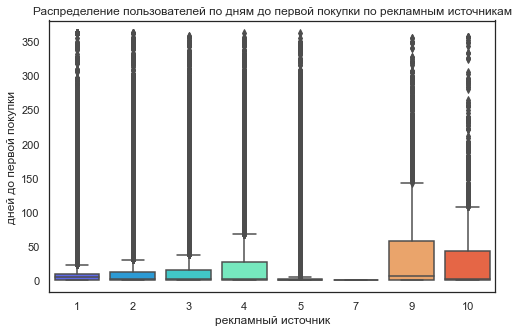

In [82]:
fig = plt.subplots(figsize=(8,5))
plt.title('Распределение пользователей по дням до первой покупки по рекламным источникам')
plot = sns.boxplot(x='source_id', y='buy_visit_days', data=visit_buy, palette='rainbow')
plt.xlabel('рекламный источник')
plt.ylabel('дней до первой покупки');

Наблюдаем явные различия в количестве дней до первой покупки, необходимые пользователям, пришедшим из разных рекламных источников. Рассмотрим укрупнённый график, исключив из него отдельные крупные "выбросы".

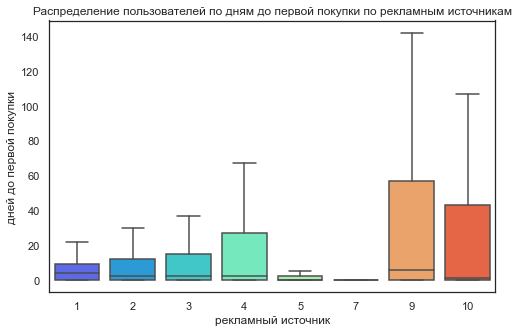

In [83]:
fig = plt.subplots(figsize=(8,5))
plt.title('Распределение пользователей по дням до первой покупки по рекламным источникам')
plot = sns.boxplot(x='source_id', y='buy_visit_days', data=visit_buy, palette='rainbow', showfliers=False)
plt.xlabel('рекламный источник')
plt.ylabel('дней до первой покупки');

Прослеживается следующая тенденция в зависимости от рекламного источника. Большинство пользователей, пришедших из седьмого рекламного источника, делает покупки моментально. Пользователи из пятго источника также домтаточно быстро совершают первую покупку. Немного больше требуется времени тем, кто пришёл из первого, второго и третьего рекламных источников. До 75% пользователям, пришедшим из четвёртого рекламного источника, требуется до 20 дней с первого посещения сайта для совершения покупки. Самыми "медлительными" являются пользователи, пришедшие из десятого и девятого рекламных источников: для 75% из них требуется до 40 и 60 дней, соответственно.

#### Количество покупок за период

Изучим, как изменяется количество покупающих пользователей внутри одной когорты. Это позволит понять, сколько людей продолжают покупать в следующих месяцах после совершения первой покупки.

In [84]:
# Получим первое число месяца, в котором произошли покупки (первая и текущая)
orders['first_buy_month'] = orders['first_buy_date'].astype('datetime64[M]')
orders['buy_month'] = orders['buy_date'].astype('datetime64[M]')

# Построим сводную таблицу
cnt_orders = orders.pivot_table(index='first_buy_month',
                                columns='buy_month',
                                values='uid',
                                aggfunc='nunique')
cnt_orders.fillna('')

buy_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_buy_month,,,,,,,,,,,,,
2017-06-01,2023,61,50,54,88,67,62,47,58,45,45,53,
2017-07-01,,1923,52,57,64,49,38,36,39,42,22,26,
2017-08-01,,,1370,58,53,44,40,32,30,44,19,31,
2017-09-01,,,,2581,130,100,74,52,64,66,37,43,
2017-10-01,,,,,4340,206,123,92,93,72,56,67,
2017-11-01,,,,,,4081,222,120,106,81,48,62,
2017-12-01,,,,,,,4383,146,103,97,50,63,
2018-01-01,,,,,,,,3373,114,83,43,45,
2018-02-01,,,,,,,,,3651,118,58,39,


Отметим, что после первого месяца количество покупателей в когорте значительно снижается - эту же тенденцию мы наблюдали по количеству входов на сайт. Практически во всех когортах число покупателей периодически начинает незначительно расти. Количество покупателей уменьшается во всех когортах в ноябре 2017 - январе 2018 года; а также значительно сокращается в апреле 2018 года. Причины этого могут быть теми же, что и для снижения пользовательских сессий на сайте в те же периоды.

Изучим долю покупателей в каждой когорте за период.

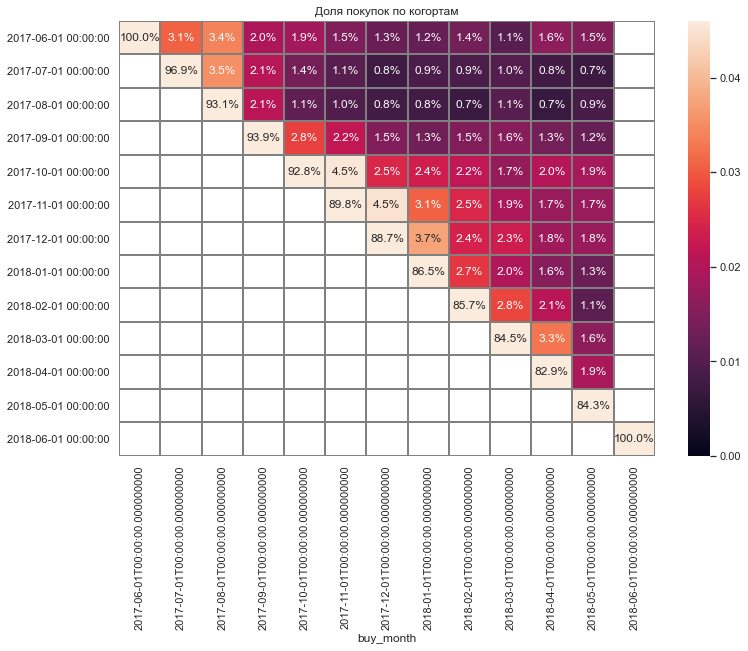

In [85]:
pt_cnt_orders = pd.DataFrame()
for column in cnt_orders.columns:
    pt_cnt_orders = pd.concat([pt_cnt_orders, (cnt_orders[column]/
                                               sum(cnt_orders.loc[(cnt_orders[column].isna() != True), column]))], axis=1)
pt_cnt_orders.columns = cnt_orders.columns
pt_cnt_orders.fillna('')

sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Доля покупок по когортам')
sns.heatmap(pt_cnt_orders, annot=True, fmt='.1%', vmin=0, vmax=0.046, linewidths=1, linecolor='gray');

Если не брать во внимание месяц первой покупки и покупки в следующий месяц после первой покупки, пользователи октябрьской когорты составляли большую долю покупателей даже через несколько месяцев после первой покупки.

In [86]:
cnt_orders_month = orders.groupby('buy_month').agg({'uid':'nunique'}).reset_index()
cnt_orders_mean = cnt_orders_month['uid'].median()
print('Среднее количество покупок за рассматриваемый период составляет {:.0f}.'.format(cnt_orders_mean))

Среднее количество покупок за рассматриваемый период составляет 3544.


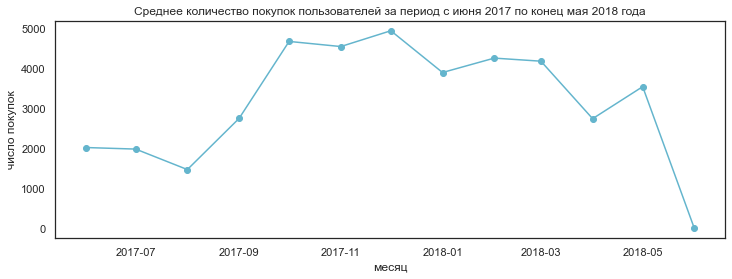

In [87]:
fig, ax = plt.subplots(figsize=(12,4))
ax.set(title='Среднее количество покупок пользователей за период с июня 2017 по конец мая 2018 года',
       xlabel='месяц', ylabel='число покупок')
ax.plot(cnt_orders_month['buy_month'], cnt_orders_month['uid'], 'o-c')
ax.grid=True
plt.show()

Наблюдался спад покупок в августе 2017 года, затем был сильный скачёк, в результате которого среднее количество покупок пользователей достигло "пика" в декабре 2017 года. Затем произошёл спад до уровня, который также продержался три месяца, после чего в апреле 2018 года было сильное падение. В мае 2018 года показатель поднялся, почти достигнув уровня января-марта 2018 года. В июне 2018 года была всего одна покупка, но, возможно, это связано с неполнотой собранных данных по последнему месяцу анализируемого периода.

Для анализа показателя по типу устройств и рекламным источникам добавим в таблицу с покупками соответствующие столбцы из таблицы с посещениями.

In [88]:
orders_device_source = orders.merge(visits, on=['uid', 'first_visit_date'], how='left')
orders_device_source.drop(['buy_ts', 'start_ts', 'end_ts', 'visit_year', 'visit_month', 'visit_week', 'visit_date', 
                           'sess_dur_sec', 'first_visit_month', 'activity_month', 'cohort_lifetime'], 
                          axis='columns', inplace=True)
orders_device_source = orders_device_source.drop_duplicates().reset_index(drop=True)

*Количество покупок по типу устройства*

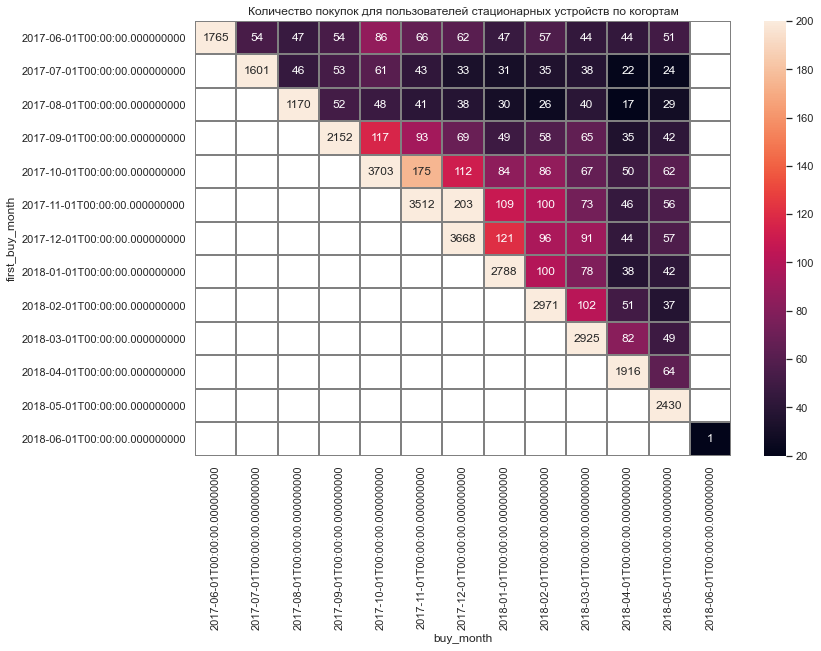

In [89]:
# Построим сводную таблицу для стационарного устройства
cnt_orders_desktop = orders_device_source.query('device == "desktop"').pivot_table(index='first_buy_month',
                                                                                   columns='buy_month',
                                                                                   values='uid',
                                                                                   aggfunc='nunique')
cnt_orders_desktop.fillna('')

# Построим тепловую карту
sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Количество покупок для пользователей стационарных устройств по когортам')
sns.heatmap(cnt_orders_desktop, annot=True, fmt='.0f', vmin=20, vmax=200, linewidths=1, linecolor='gray');

По количеству покупок имеем те же закономерности для пользователей стационарных устройств, что и для общей выборки: наибольшее число покупок во все периоды совершала октябрьская когорта.

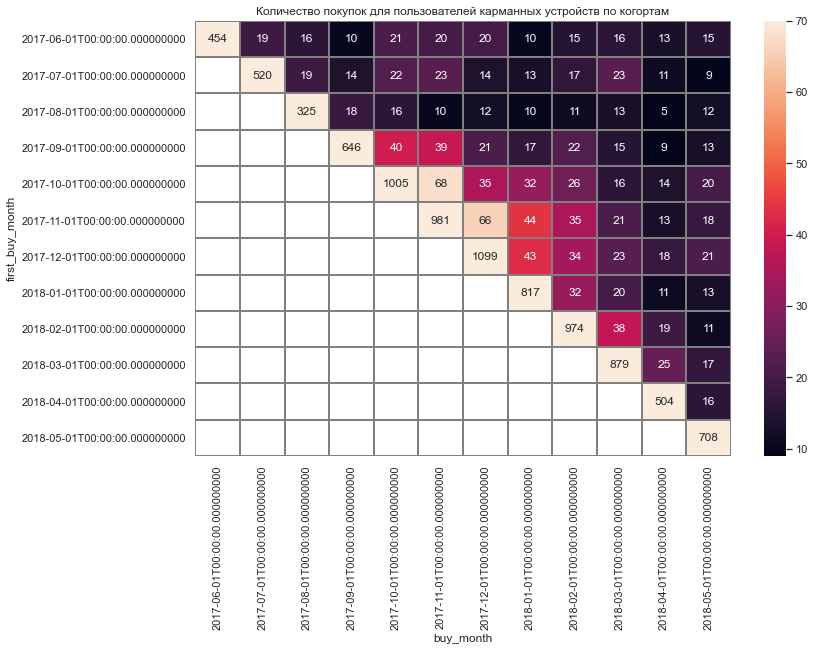

In [90]:
# Построим сводную таблицу для карманного устройства
cnt_orders_touch = orders_device_source.query('device == "touch"').pivot_table(index='first_buy_month',
                                                                               columns='buy_month',
                                                                               values='uid',
                                                                               aggfunc='nunique')
cnt_orders_touch.fillna('')

# Построим тепловую карту
sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Количество покупок для пользователей карманных устройств по когортам')
sns.heatmap(cnt_orders_touch, annot=True, fmt='.0f', vmin=9, vmax=70, linewidths=1, linecolor='gray');

Для пользователей карманных устройств нет таких больших изменений в количестве покупок после первого месяца (на второй месяц), как для пользователей стационарных устройств. Октябрьская когорта также характеризуется наибольшим значением количества покупок. Самый низкий показатель у августовской когорты.

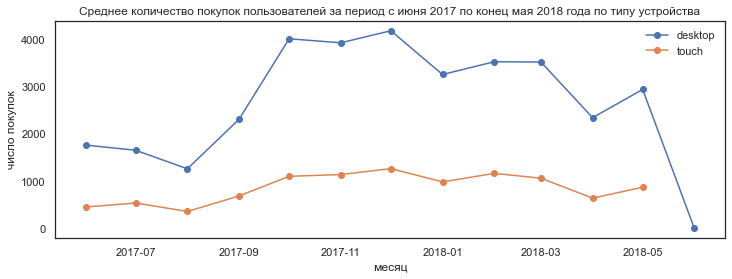

In [91]:
# Построим график динамики
cnt_orders_device_month = orders_device_source.groupby(['device', 'buy_month']).agg({'uid':'nunique'}).reset_index()
fig, ax = plt.subplots(figsize=(12,4))
ax.set(title='Среднее количество покупок пользователей за период с июня 2017 по конец мая 2018 года по типу устройства',
       xlabel='месяц', ylabel='число покупок')
for device in cnt_orders_device_month['device'].unique():
    ax.plot(cnt_orders_device_month.query('device == @device')['buy_month'], 
            cnt_orders_device_month.query('device == @device')['uid'], 'o-', label=device)
ax.grid=True   
ax.legend(frameon=False);

На графике видим ту же динамику, что и на тепловых картах. Пользователи карманных устройств имеют меньше колебаний в покупках, чем пользователи стационарных устройств. Также видим, что с сентября 2017 года доля покупок на стационарных устройствах значительно выросла. Что касается динамики показателей, они изменялись симметрично, но разным темпом роста.

Выбивающаяся покупка пользователя стационарного устройства в июне 2018 года может быть связана с неполнотой данных на этот период.

*Количество покупок по рекламному источнику*

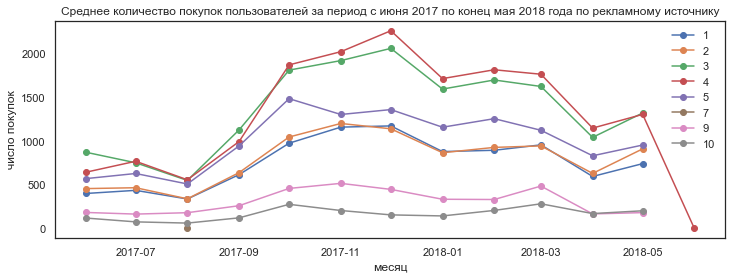

In [92]:
# Построим график динамики
cnt_orders_source_month = orders_device_source.groupby(['source_id', 'buy_month']).agg({'uid':'nunique'}).reset_index()
fig, ax = plt.subplots(figsize=(12,4))
ax.set(title='Среднее количество покупок пользователей за период с июня 2017 по конец мая 2018 года по рекламному источнику',
       xlabel='месяц', ylabel='число покупок')
for source in cnt_orders_source_month['source_id'].unique():
    ax.plot(cnt_orders_source_month.query('source_id == @source')['buy_month'], 
            cnt_orders_source_month.query('source_id == @source')['uid'], 'o-', label=source)
ax.grid=True   
ax.legend(frameon=False);

По типу рекламного источника наблюдаем следующую динамику количества покупок. Наибольшее число покупок было сделано пользователями, пришедшими из третьего и четвёртого рекламных источников. Причём до сентября 2017 года включительно больше покупали пользователи из 3 источника, а в последующие периоды - пользователи из 4 источника. Также очень эффективным с точки зрения числа покупок был пятый источник. Примерно одинаковый, но чуть меньший эффект, имели первый и второй источники: по ним покупатели совершили приблизительно равное количество покупок во все месяцы исследуемого периода. Девятый источник побудил пользователей к совершению небольшого числа покупок, а десятый - к ещё меньшему. Самым неэффективным был седьмой рекламный источник: пользователь совершил всего одну покупку в августе 2017 года, и больше покупок от тех, кто пришёл из этого источника, не было.

#### Средний чек

Сначала рассчитаем величину среднего чека, в целом.

In [93]:
revenue_mean = orders['revenue'].mean()
print('Величина среднего чека составила {:.2f} ден.ед.'.format(revenue_mean))

Величина среднего чека составила 5.00 ден.ед.


Теперь посмотрим динамику выручки по месяцам для каждой когорты. В качестве когорты выделим пользователей, совершивших первую покупку в тот или иной месяц.

In [94]:
sum_revenue = orders.pivot_table(index='first_buy_month',
                                columns='buy_month',
                                values='revenue',
                                aggfunc='sum')
sum_revenue.fillna('')

buy_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_buy_month,,,,,,,,,,,,,
2017-06-01,9557.49,981.82,885.34,1931.3,2068.58,1487.92,1922.74,1176.56,1119.15,1225.51,1155.66,519.62,
2017-07-01,,11557.6,644.61,1199.05,690.31,339.97,300.08,231.16,272.72,310.05,282.96,299.36,
2017-08-01,,,7228.83,646.63,628.12,536.05,676.85,388.45,288.61,554.86,400.33,257.53,
2017-09-01,,,,14568.5,2884.49,1344.52,10261.5,1033.84,1670.08,1810.85,627.57,474.92,
2017-10-01,,,,,21716.2,2325.21,830.65,682.01,657.77,522.37,368.1,501.14,
2017-11-01,,,,,,21036.3,1629.27,814.39,1326.13,604.04,219.88,469.02,
2017-12-01,,,,,,,20767.5,1141.22,4054.7,4669.1,1371.57,1481.66,
2018-01-01,,,,,,,,13949.5,994.22,1026.34,481.59,211.48,
2018-02-01,,,,,,,,,15177.2,1015.98,286.66,270.7,


Рассчитаем средний чек по когортам, разделив выручку на соответствующее когорте значение количества покупок.

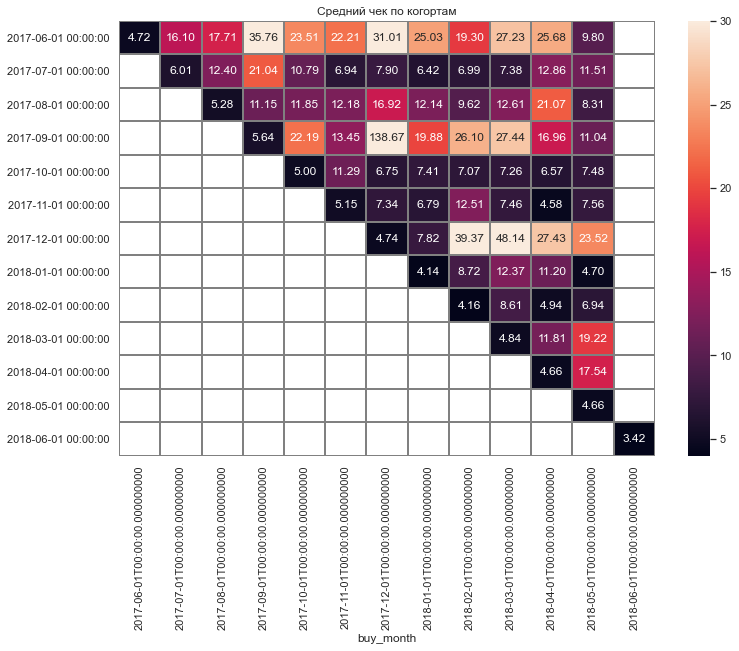

In [95]:
rev_per_user = pd.DataFrame()
for column in sum_revenue.columns:
    rev_per_user = pd.concat([rev_per_user, (sum_revenue[column]/cnt_orders[column])], axis=1)
rev_per_user.columns = sum_revenue.columns
rev_per_user.fillna('')

sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Средний чек по когортам')
sns.heatmap(rev_per_user, annot=True, fmt='.2f', vmin=4, vmax=30, linewidths=1, linecolor='gray');

Полученная нами величина среднего чеков для всей совокупности данных близка к значениям среднего чека для всех представителей когорты в месяц их первой покупки. Напомним, что именно в месяц первой покупки пользователей больше всего в каждой из когорт. В дальнейшем показатель среднего чека выше (около 7-11 ден.ед.), хотя пользователей и меньше. Выделяется июльская когорта, сентябрьская когорта и декабрьская когорта: там величина среднего чека наиболее высокая в последующие месяцы. Особо следует выделить средний чек в декабре для сентябрьской когорты: он составил 138,67 ден.ед.

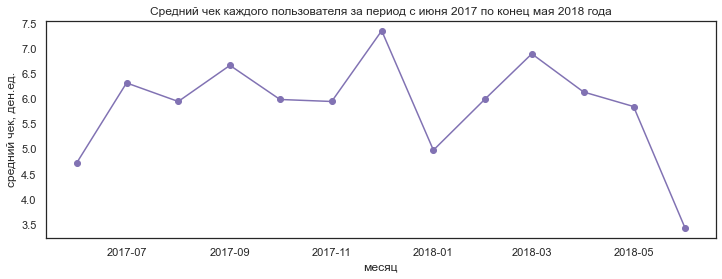

In [96]:
revenue_month = orders.groupby('buy_month').agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
revenue_month['rev_per_user'] = round((revenue_month['revenue'] / revenue_month['uid']), 2)

fig, ax = plt.subplots(figsize=(12,4))
ax.set(title='Средний чек каждого пользователя за период с июня 2017 по конец мая 2018 года',
       xlabel='месяц', ylabel='средний чек, ден.ед.')
ax.plot(revenue_month['buy_month'], revenue_month['rev_per_user'], 'o-m')
ax.grid=True
plt.show()

Наблюдаем следующую динамику величины среднего чека по каждому пользователю: в июле 2017 года средний чек вырос, затем снизился. В сентябре 2017 снова наблюдался небольшой рост, после чего был спад показателя до величины сентября (около 6 ден.ед.), который продержался 2 месяца. В декабре был очень большой рост среднего чека, что может быть связано с сезонностью (новогодние мероприятия), после чего произошёл значительный спад до уровня июня 2017 года. В феврале снова был достигнут уровень августа  и октября-ноября 2017 года; затем был небольшой рост; после чего в апреле-мае 2018 года показатель вернулся к отметке около 6 ден.ед.; а в июне 2018 года был очень сильный спад до 3,5 ден.ед. Однако, ранее мы указывали на то, что показатель июня 2018 может быть недостоверным из-за недостатка данных по покупкам.

*Средний чек по типу устройства*

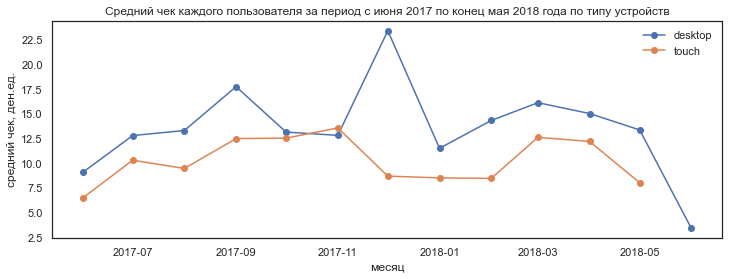

In [97]:
revenue_device_month = (orders_device_source
                         .groupby(['device', 'buy_month'])
                         .agg({'revenue':'sum', 'uid':'nunique'})
                         .reset_index()
                        )
revenue_device_month['rev_per_user'] = round((revenue_device_month['revenue'] / revenue_device_month['uid']), 2)

fig, ax = plt.subplots(figsize=(12,4))
ax.set(title='Средний чек каждого пользователя за период с июня 2017 по конец мая 2018 года по типу устройств',
       xlabel='месяц', ylabel='средний чек, ден.ед.')
for device in revenue_device_month['device'].unique():
    ax.plot(revenue_device_month.query('device == @device')['buy_month'], 
            revenue_device_month.query('device == @device')['rev_per_user'], 'o-', label=device)
ax.grid=True
ax.legend(frameon=False);

До сентября 2017 года величина среднего чека имела схожую динамику для различных типов устройств. Однако после того, как доля покупок со стационарных устройств начала расти, средний чек для этого типа устройств снизился, в то время как для карманных устройств он оставался практически на том же уровне. В ноябре 2017 года имелась иная динамика: средний чек пользователей стационарных устройств имел сильный "скачёк" вверх и достиг максимального значения около 22,5; но для пользователей мобильных устройств он сократился до 7,5, где продержался до февраля 2018 года. У пользователей стационарных устройств в январе 2018 года средний чек вернулся к близкому до "скачка" значению, после чего начал расти до марта 2018 года. В апреле-мае 2018 года наблюдалось падение среднего чека для всех устройств.

В целом, динамика среднего чека пользователей карманных устройств имеет более плавную динамику и менее резкие изменения, чем динамика среднего чека пользователей стационарных устройств.

*Средний чек по рекламному источнику*

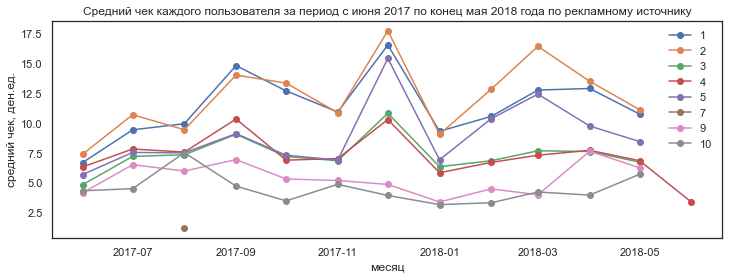

In [98]:
revenue_source_month = (orders_device_source
                         .groupby(['source_id', 'buy_month'])
                         .agg({'revenue':'sum', 'uid':'nunique'})
                         .reset_index()
                        )
revenue_source_month['rev_per_user'] = round((revenue_source_month['revenue'] / revenue_source_month['uid']), 2)

fig, ax = plt.subplots(figsize=(12,4))
ax.set(title='Средний чек каждого пользователя за период с июня 2017 по конец мая 2018 года по рекламному источнику',
       xlabel='месяц', ylabel='средний чек, ден.ед.')
for source in revenue_source_month['source_id'].unique():
    ax.plot(revenue_source_month.query('source_id == @source')['buy_month'], 
            revenue_source_month.query('source_id == @source')['rev_per_user'], 'o-', label=source)
ax.grid=True
ax.legend(frameon=False);

Наибольший средний чек, практически на всём рассматриваемом периоде наблюдался у пользователей, пришедших из второго рекламного источника; в некоторые месяцы он совпадал со средним чеком пользователей из первого источника. Однако, в феврале-марте 2018 года средний чек пользователей из первого источника был существенно (по сравнению с другими месяцами) ниже. Также высокие показатели среднего чека ежемесячно показывали пользователи из пятого рекламного источника. На среднем уровне по среднему чеку с практически идентичными месячными значениями находятся пользователи из третьего и четвёртого рекламных источников. Меньшее значения показывают пользователи из девятого и десятого рекламных источников, причём показатель 10 источника, как правило, ниже. Пользователь, пришедший из 7 источника, показал не только всего одну покупку, но и самый наименьший результат по среднему чеку по этой покупке: всего 1,22 ден.ед.

#### Расчёт Lifetime Value (LTV)

У нас есть данные о месяце первой покупки каждого пользователя. Посчитаем количество новых покупателей за каждый месяц.

In [99]:
cohort_sizes = orders.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'n_buyers']
print(cohort_sizes)

   first_buy_month  n_buyers
0       2017-06-01      2023
1       2017-07-01      1923
2       2017-08-01      1370
3       2017-09-01      2581
4       2017-10-01      4340
5       2017-11-01      4081
6       2017-12-01      4383
7       2018-01-01      3373
8       2018-02-01      3651
9       2018-03-01      3533
10      2018-04-01      2276
11      2018-05-01      2988
12      2018-06-01         1


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. После чего добавим в получившуюся таблицу данные о том, сколько людей первый раз совершили покупку в каждый месяц.

In [100]:
buy_cohorts = orders.groupby(['first_buy_month','buy_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, buy_cohorts, on='first_buy_month')

У нас нет данных о маржинальности покупок, соответственно, мы можем рассматривать валовую прибыль, равную выручке. Предположим, что Яндекс.Афиша получает фиксированный доход (или процент) от покупки, не неся каких-либо затрат с единицы услуги (то есть с нулевой себестоимостью). Возможно, в реальности это не так, но и данных, опровергающих это, у нас также нет. Соответственно, показатель LTV будет рассчитан на основе выручки, а не валовой прибыли.

Добавим для удобства в таблицу номер жизненного цикла (lifetime) для когорты и найдём LTV, разделив валовую прибыль (выручку) когорт за каждый месяц на общее число пользователей в каждой когорте. Результат проиллюстрируем на тепловой карте.

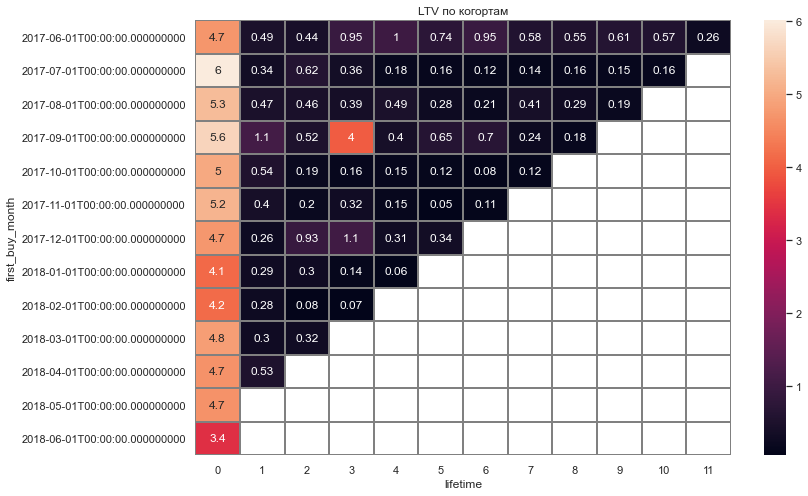

In [101]:
report['lifetime'] = ((report['buy_month'] - report['first_buy_month']) / np.timedelta64(1, 'M')).round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']

ltv = report.pivot_table(index='first_buy_month', 
                         columns='lifetime', 
                         values='ltv', 
                         aggfunc='mean').round(2)
ltv.fillna('')

sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('LTV по когортам')
sns.heatmap(ltv, annot=True, linewidths=1, linecolor='gray');

Видим, что средний пользователь приносит больше всего денег в нулевой период (то есть в месяц первой покупки).
Посчитаем итоговый LTV июньской и сентябрьской когорт, поскольку июньская когорта - самая стабильная по показателю, а на третий месяц после первой покупки сентябрьской когорты наблюдалось очень большое значение LTV.

In [102]:
ltv.cumsum(axis=1).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,
2017-12-01,4.74,5,5.93,7,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,


Видим, что большая часть когорт принесла около 4,5-6 ден.ед. за период. Однако, выделяются июньская и сентябрьская когорты, оказавшиеся самыми доходными.

In [103]:
ltv_201706 = ltv.loc['2017-06-01'].sum()
ltv_201709 = ltv.loc['2017-09-01'].sum()
print('В среднем каждый покупатель из июньской когорты принес по {} ден.ед. выручки, а каждый покупатель из сентябрьской \
когорты - {} ден.ед. выручки за год «жизни».'.format(ltv_201706, ltv_201709))

В среднем каждый покупатель из июньской когорты принес по 11.88 ден.ед. выручки, а каждый покупатель из сентябрьской когорты - 13.43 ден.ед. выручки за год «жизни».


*LTV по типу устройства*

Сделаем те же шаги, но по отношению к Датафрейму с типом устройства.

In [104]:
cohort_device_sizes = orders_device_source.groupby(['device', 'first_buy_month']).agg({'uid': 'nunique'}).reset_index()
cohort_device_sizes.columns = ['device', 'first_buy_month', 'n_buyers']

buy_device_cohorts = (orders_device_source
                      .groupby(['device','first_buy_month','buy_month'])
                      .agg({'revenue': 'sum'})
                      .reset_index()
                     )
report_device = pd.merge(cohort_device_sizes, buy_device_cohorts, on=['device', 'first_buy_month'])

report_device['ltv'] = report_device['revenue'] / report_device['n_buyers']

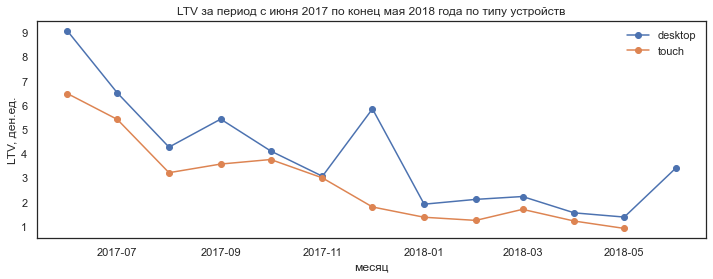

In [105]:
report_device_pivot = report_device.pivot_table(index=['device', 'buy_month'],
                                               values='ltv',
                                               aggfunc='mean').reset_index()

fig, ax = plt.subplots(figsize=(12,4))
ax.set(title='LTV за период с июня 2017 по конец мая 2018 года по типу устройств',
       xlabel='месяц', ylabel='LTV, ден.ед.')
for device in report_device_pivot['device'].unique():
    ax.plot(report_device_pivot.query('device == @device')['buy_month'], 
            report_device_pivot.query('device == @device')['ltv'], 'o-', label=device)
ax.grid=True
ax.legend(frameon=False);

Наибольшее значение LTV наблюдалось в июне 2017 года для всех типов устройств. Далее показатель снижался, однако для сационарных устройств был внезапный рост в декабре 2017 года. В целом же показатель LTV для пользователей стационарных устройств был близок к показателю для пользователей карманных устройств.

*LTV по рекламному источнику*

Сделаем те же шаги, но по отношению к Датафрейму с типом рекламного источника.

In [106]:
cohort_source_sizes = orders_device_source.groupby(['source_id', 'first_buy_month']).agg({'uid': 'nunique'}).reset_index()
cohort_source_sizes.columns = ['source_id', 'first_buy_month', 'n_buyers']

buy_source_cohorts = (orders_device_source
                      .groupby(['source_id','first_buy_month','buy_month'])
                      .agg({'revenue': 'sum'})
                      .reset_index()
                     )
report_source = pd.merge(cohort_source_sizes, buy_source_cohorts, on=['source_id', 'first_buy_month'])

report_source['ltv'] = report_source['revenue'] / report_source['n_buyers']

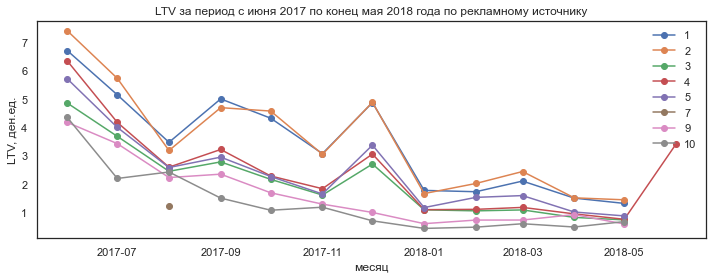

In [107]:
report_source_pivot = report_source.pivot_table(index=['source_id', 'buy_month'],
                                                values='ltv',
                                                aggfunc='mean').reset_index()

fig, ax = plt.subplots(figsize=(12,4))
ax.set(title='LTV за период с июня 2017 по конец мая 2018 года по рекламному источнику',
       xlabel='месяц', ylabel='LTV, ден.ед.')
for source in report_source_pivot['source_id'].unique():
    ax.plot(report_source_pivot.query('source_id == @source')['buy_month'], 
            report_source_pivot.query('source_id == @source')['ltv'], 'o-', label=source)
ax.grid=True
ax.legend(frameon=False);

Динамика LTV для рекламных источников близка с общей динамикой, кроме пользователей из девятого и десятого источников - для них не было увеличения показателя в декабре 2017 года. Самыми доходными по LTV были пользователи из первого и второго источников; среднюю доходность показали 5, 4 и 3 источники; наименьшую - 9 и 10. Седьмой источник был абсолютно неэффективен по LTV.

### Вывод по торговым метрикам <a id='step_3.4'></a>

**Среднее время между покупкой и первым входом** пользователя на сайт = 0 дней. **Среднее количество покупок** за период = 3544. **Средний чек** = 5 ден.ед. **Среднее LTV** по когортам = 4,5-6 ден.ед. **Максимальное LTV** для июньской и сентябрьской когорт составило 11,88 ден.ед. и 13,43 ден.ед., соответственно.

Достаточно большое число пользователей совершает покупку в тот же день, что и входит на сайт, вне зависимости от типа устройства и рекламного источника. Есть и те, кто покупает на несколько дней позже, и даже практически через год после первого входа (363 дня). Причём больший разброс количества дней до покупки характерен для пользователей карманных устройств (для 75% пользователей устройств этот период составил до 100 дней). Это может быть связано с неудобством совершения покупки с мобильной версии сайта. Таким образом, пользователи могут отложить покупку и совершить её со стационарного устройства. Однако, часть таких пользователей может уйти в этом процессе, либо забыть о покупке.

Наблюдаем явные различия и в разбросе количества дней до первой покупки, необходимых пользователям, пришедшим из разных рекламных источников. Большинство пользователей, пришедших из *7 рекламного источника*, делает покупки моментально. Пользователи из *5 источника* также достаточно быстро совершают первую покупку. Немного больше требуется времени тем, кто пришёл из *1, 2 и 3 рекламных источников*. До 75% пользователям, пришедшим из *4 рекламного источника*, требуется до 20 дней с первого посещения сайта для совершения покупки. Самыми "медлительными" являются пользователи, пришедшие из *10 и 9 рекламных источников*: для 75% из них требуется до 40 и 60 дней, соответственно.

Однако, общие закономерности показывают, что пользователи входят на сайт с целью совершения покупки; соответственно, главным в рекламной кампании должно быть привлечение клиента к сайту. Также было выявлено, что 28555 пользователей заходило на сайт, но не совершило покупок. Для таких пользователей характерны сессии длительностью 0 секунд. То есть они либо случайно зашли на сайт, либо имели проблемы с его загрузкой и моментально уходили с сайта.

Похожая тенденция проявляется и в количестве покупателей. После первого месяца количество покупателей в когортах (когорты были выделены по месяцу первой покупки) значительно снижается. Практически во всех когортах число покупателей периодически начинает незначительно расти; а в ноябре 2017 - январе 2018 и апреле 2018 года снижается. Причины этого могут быть теми же, что и для снижения пользовательских сессий на сайте в те же периоды. Если не брать во внимание месяц первой покупки и покупки в следующий месяц после первой покупки, пользователи октябрьской когорты составляли большую долю покупателей даже через несколько месяцев после первой покупки.

По количеству покупок без разделения когорт мы выидим следующие тенденции. Наблюдался спад покупок в августе 2017 года, затем был сильный скачёк, в результате которого среднее количество покупок пользователей достигло "пика" в декабре 2017 года. Затем произошёл спад до уровня, который также продержался три месяца, после чего в апреле 2018 года было сильное падение. В мае 2018 года показатель поднялся, почти достигнув уровня января-марта 2018 года. В июне 2018 года была всего одна покупка, но, возможно, это связано с неполнотой собранных данных по последнему месяцу анализируемого периода.

По количеству покупок имеем те же закономерности для пользователей стационарных устройств, что и для общей выборки: наибольшее число покупок во все периоды совершала октябрьская когорта. Для пользователей карманных устройств нет таких больших изменений в количестве покупок после первого месяца (на второй месяц), как для пользователей стационарных устройств. Октябрьская когорта также характеризуется наибольшим значением количества покупок. Самый низкий показатель у августовской когорты. Также видим, что с сентября 2017 года доля покупок на стационарных устройствах значительно выросла. Что касается динамики показателей, они изменялись симметрично, но с разным темпом роста.

По типу рекламного источника наблюдаем следующую динамику для количества покупок. Наибольшее число покупок было сделано пользователями, пришедшими из *3 и 4 рекламных источников*. Причём до сентября 2017 года включительно больше покупали пользователи из *3 источника*, а в последующие периоды - пользователи из *4 источника*. Также очень эффективным с точки зрения числа покупок был *5 источник*. Примерно одинаковый, но чуть меньший эффект, имели *1 и 2 источники*: по ним покупатели совершили приблизительно равное количество покупок во все месяцы исследуемого периода. *9 источник* побудил пользователей к совершению небольшого числа покупок, а *10 источник* - к ещё меньшему. Самым неэффективным был *7 рекламный источник*: пользователь совершил всего одну покупку в августе 2017 года, и больше покупок от него не было.

По величине среднего чека выделяется июльская когорта, сентябрьская когорта и декабрьская когорта: там величина среднего чека наиболее высокая в последующие за первой покупкой месяцы. Особо следует выделить средний чек в декабре для сентябрьской когорты: он составил 138,67 ден.ед. Наблюдаем следующую динамику величины среднего чека по каждому пользователю: в июле 2017 года средний чек вырос, затем снизился. В сентябре 2017 снова наблюдался небольшой рост, после чего был спад показателя до величины сентября (около 6 ден.ед.), который продержался 2 месяца. В декабре был очень большой рост среднего чека, что может быть связано с сезонностью (новогодние мероприятия), после чего произошёл значительный спад до уровня июня 2017 года. В феврале снова был достигнут уровень августа и октября-ноября 2017 года; затем был небольшой рост; после чего в апреле-мае 2018 года показатель вернулся к отметке около 6 ден.ед.; а в июне 2018 года был очень сильный спад до 3,5 ден.ед. Однако, ранее мы указывали на то, что показатель июня 2018 может быть недостоверным из-за недостатка данных по покупкам.

До сентября 2017 года величина среднего чека имела схожую динамику для различных типов устройств. Однако после того, как доля покупок со стационарных устройств начала расти, средний чек для этого типа устройств снизился, в то время как для карманных устройств он оставался практически на том же уровне. В ноябре 2017 года имелась иная динамика: средний чек пользователей стационарных устройств имел сильный "скачёк" вверх и достиг максимального значения около 22,5; но для пользователей мобильных устройств он сократился до 7,5, где продержался до февраля 2018 года. У пользователей стационарных устройств в январе 2018 года средний чек вернулся к близкому до "скачка" значению, после чего начал расти до марта 2018 года. В апреле-мае 2018 года наблюдалось падение среднего чека для всех устройств. В целом, динамика среднего чека пользователей карманных устройств имеет более плавную динамику и менее резкие изменения, чем динамика среднего чека пользователей стационарных устройств.

Анализ динамики среднего чека по рекламным источникам показал, что наибольшая величина метрики практически на всём рассматриваемом периоде наблюдается у пользователей, пришедших из *2 рекламного источника*; в некоторые месяцы она совпадала со средним чеком пользователей из *1 источника*. Однако, в феврале-марте 2018 года средний чек пользователей из *1 источника* был существенно (по сравнению с другими месяцами) ниже. Также высокие показатели среднего чека ежемесячно показывали пользователи из *5 рекламного источника*. На среднем уровне по среднему чеку с практически идентичными месячными значениями находятся пользователи из *3 и 4 рекламных источников*. Меньшие значения показывают пользователи из *9 и 10 рекламных источников*, причём показатель *10 источника*, как правило, ниже. Пользователь, пришедший из *7 источника*, показал не только всего одну покупку, но и самый наименьший результат по среднему чеку по этой покупке: всего 1,22 ден.ед.

Необходимо отметить, что при расчёте LTV мы обнаружили отсутствие данных о маржинальности покупок, соответственно, было сделано предположение о том, что маржинальность равна единице, а себестоимость услуг нулевая. Соответственно, показатель LTV был рассчитан на основе выручки, а не валовой прибыли. Когортный анализ динамики LTV показал, что средний пользователь приносит больше всего денег в нулевой период (то есть в месяц первой покупки). Июньская когорта является самой стабильной по показателю, а на третий месяц после первой покупки сентябрьской когорты наблюдается очень большое значение LTV. Именно поэтому эти две когорты были отдельно выделены в качестве метрик.

Наибольшее значение LTV наблюдалось в июне 2017 года для всех типов устройств. Далее показатель снижался, однако для стационарных устройств был внезапный рост в декабре 2017 года. В целом же показатель LTV для пользователей стационарных устройств был близок к показателю для пользователей карманных устройств. Динамика LTV для рекламных источников близка с общей динамикой, кроме пользователей из *9 и 10 источников* - для них не было увеличения показателя в декабре 2017 года. Самыми доходными по LTV были пользователи из *1 и 2 источников*; среднюю доходность показали *5, 4 и 3 источники*; наименьшую - *9 и 10 рекламный источники*. *7 источник* был абсолютно неэффективен по LTV.

### 3. Маркетинговые метрики <a id='step_3.5'></a>

#### Количество потраченных денег

*Всего на рекламу*

In [108]:
total_costs = costs['costs'].sum()
print('Всего на рекламу было потрачено {} ден.ед.'.format(total_costs))

Всего на рекламу было потрачено 329131.62 ден.ед.


*На каждый рекламный источник*

In [109]:
source_costs = (costs
                .pivot_table(index='source_id',
                             values='costs',
                             aggfunc='sum')
                .reset_index()
                .sort_values(by='costs', ascending=False)
                .reset_index(drop=True)
               )
source_costs

,source_id,costs
0,3,141321.63
1,4,61073.60
2,5,51757.10
3,2,42806.04
4,1,20833.27
5,10,5822.49
6,9,5517.49


Больше всего денег было потрачено на третий рекламный источник (141 321,63 ден.ед), чуть меньше - на четвёртый (61 073,6 ден.ед.), пятый (51 757,1 ден.ед.) и второй (42 806,04 ден.ед.). На первый рекламный источник привлечения посетителей потратили 20 833,27 ден.ед. И на 10 и 9 источники потратили 5 822,49 ден.ед. и 5 517,49 ден.ед., соответственно.

Соберём затраты по дате рекламной кампании и источникам, и изобразим на графике.

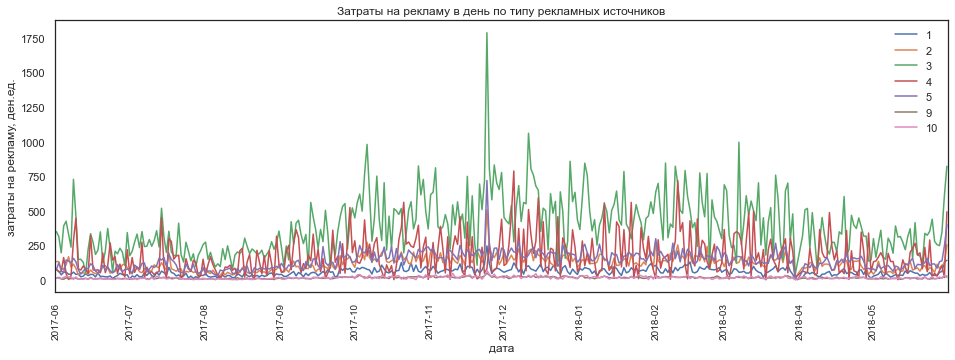

In [110]:
date_source_costs = costs.pivot_table(index=['source_id', 'dt'],
                                     values='costs',
                                     aggfunc='sum').reset_index()
fig, ax = plt.subplots(figsize=(16,5))
ax.set(title='Затраты на рекламу в день по типу рекламных источников', xlabel='дата', ylabel='затраты на рекламу, ден.ед.')
source_plot(date_source_costs, 'dt', 'costs')

Реклама проводилась периодически. В большей степени общие тенденции рекламных затрат по источникам совпадают с тенденциями по датам проведения рекламных кампаний. Таким образом, можем сделать вывод о том, что порядок затрат по рекламным источникам сохранялся на протяжении всего периода.

*По времени затрат на рекламу*

Добавим в Датафрейм затрат столбец с первым числом месяца, в котором была проведена рекламная кампания.

In [111]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]')

Изучим динамику затрат на рекламу по месяцам.

In [112]:
month_costs = costs.pivot_table(index='costs_month',
                               values='costs',
                               aggfunc='sum').reset_index()
month_costs.sort_values(by='costs', ascending=False).reset_index(drop=True)

,costs_month,costs
0,2017-12-01,38315.35
1,2017-11-01,37907.88
2,2017-10-01,36322.88
3,2018-01-01,33518.52
4,2018-02-01,32723.03
5,2018-03-01,30415.27
6,2017-09-01,24368.91
7,2018-04-01,22289.38
8,2018-05-01,22224.27
9,2017-07-01,18240.59


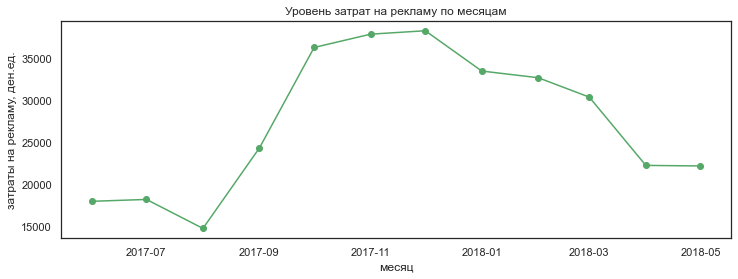

In [113]:
fig, ax = plt.subplots(figsize=(12,4))
ax.set(title='Уровень затрат на рекламу по месяцам',
       xlabel='месяц', ylabel='затраты на рекламу, ден.ед.')
ax.plot(month_costs['costs_month'], month_costs['costs'], 'o-g')
ax.grid=True
plt.show()

Больше всего денег было затрачено на рекламу в декабре 2017 года (однако, и многие метрики в этот месяц значительно увеличились): 38 315,35 ден.ед.; высоки затраты были и в ноябре 2017 года (37 907,88 ден.ед.), и в октябре 2017 года (36 322,88 ден.ед.). Чуть ниже были затраты в последующие 3 месяца: январь (33 518,52 ден.ед.), февраль (32 723,03 ден.ед.) и март (30 415,27 ден.ед.) 2018 года. На чуть меньшем уровне держались затраты других трёх месяцев: сентябрь 2017 года (24 368,91 ден.ед.), апрель (22 289,38 ден.ед.) и май (22 224,27 ден.ед.) 2018 года. И меньше всего было потрачено на рекламу в летние месяцы: июль (18 240,59 ден.ед.), июнь (18 015 ден.ед.) и август (14 790,54) 2017 года.

Для того, чтобы изучить связь между рекламными кампаниями и динамикой рассчитанных нами метрик, построим графики по месяцам по всем интересующим нас показателям. А также рассчитаем корреляцию.

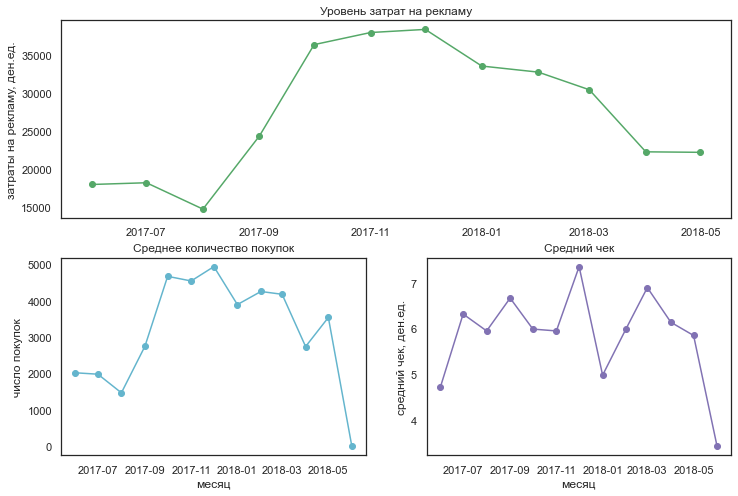

In [114]:
fig = plt.figure(figsize=(12,8))

ax_1 = fig.add_subplot(2, 1, 1)
ax_2 = fig.add_subplot(2, 2, 3)
ax_3 = fig.add_subplot(2, 2, 4)

ax_1.set(title='Уровень затрат на рекламу', ylabel='затраты на рекламу, ден.ед.')
ax_2.set(title='Среднее количество покупок', 
         xlabel='месяц', ylabel='число покупок')
ax_3.set(title='Средний чек',
         xlabel='месяц', ylabel='средний чек, ден.ед.')

ax_1.plot(month_costs['costs_month'], month_costs['costs'], 'o-g')
ax_2.plot(cnt_orders_month['buy_month'], cnt_orders_month['uid'], 'o-c')
ax_3.plot(revenue_month['buy_month'], revenue_month['rev_per_user'], 'o-m')

ax.grid=True

plt.show()

In [115]:
costs_buy_corr = month_costs['costs'].corr(cnt_orders_month['uid'])
costs_rev_corr = month_costs['costs'].corr(revenue_month['rev_per_user'])
print('Коэффициент корреляции между затратами на рекламу и средним количеством покупок пользователей составил {:.2f}, а между \
затратами на рекламу и средним чеком: {:.2f}.'.format(costs_buy_corr, costs_rev_corr))

Коэффициент корреляции между затратами на рекламу и средним количеством покупок пользователей составил 0.96, а между затратами на рекламу и средним чеком: 0.27.


Динамика количества покупок практически полностью совпадает с динамикой рекламных затрат по месяцам (что видно и по соответствующему коэффициенту корреляции), а вот на средний чек затраты на рекламу практически не влияют.

#### Стоимость привлечения одного пользователя (CAC) из рекламных источников

Добавим данные о расходах в созданный ранее отчёт report и посчитаем CAC для всех рекламных источников в совокупности.

In [116]:
# Выведем расходы за месяц
monthly_costs = costs.groupby('costs_month').sum().reset_index()
monthly_costs.drop(['source_id'], axis='columns', inplace=True)
# Добавим данные о расходах в таблицу с отчётом
report_new = pd.merge(report, monthly_costs, left_on='first_buy_month', right_on='costs_month')
# Рассчитаем CAC
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_buy_month,n_buyers,buy_month,revenue,lifetime,ltv,costs_month,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-06-01,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,2017-06-01,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,2017-06-01,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,2017-06-01,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,2017-06-01,18015.0,8.905091


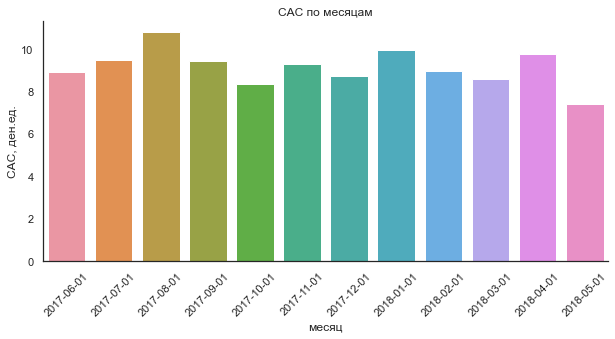

In [117]:
cac = report_new.pivot_table(index='costs_month', 
                                values='cac', 
                                aggfunc='mean').reset_index()
cac['costs_month'] = cac['costs_month'].dt.date

plot = sns.catplot("costs_month", "cac", kind="bar", data=cac)
plt.title("CAC по месяцам")
plt.xlabel('месяц')
plt.ylabel('CAC, ден.ед.')
plot.set_xticklabels(rotation=45)
plot.fig.set_size_inches(10,4);

In [118]:
cac.sort_values(by='cac', ascending=False).reset_index(drop=True)

,costs_month,cac
0,2017-08-01,10.796015
1,2018-01-01,9.937302
2,2018-04-01,9.793225
3,2017-07-01,9.485486
4,2017-09-01,9.441654
5,2017-11-01,9.288870
6,2018-02-01,8.962758
7,2017-06-01,8.905091
8,2017-12-01,8.741809
9,2018-03-01,8.608907


Самыми дорогими по стоимости привлечения оказались пользователи в августе (CAC = 11 ден.ед.). Примерно равны по показателю CAC в январе и апреле 2018 года (9,9 и 9,8 ден.ед., соответственно). Далее по уменьшению показателя идут июль, сентябрь и ноябрь (9,5, 9,4 и 9,3 ден.ед., соответственно). Ещё дешевле обошлись пользователи февраля (9 ден.ед.), декабря (8,7 ден.ед.) и марта (8,6 ден.ед.). И самыми дешёвыми по стоимости привлечения оказались пользователи октября (CAC = 8,4 ден.ед.) и мая (7,4 ден.ед.).

In [119]:
cac_mean = cac['cac'].mean()
print('Средняя стоимость привлечения одного пользователя (CAC) составила {:.2f} ден.ед.'.format(cac_mean))

Средняя стоимость привлечения одного пользователя (CAC) составила 9.15 ден.ед.


*CAC по рекламному источнику*

Добавим данные о расходах в созданный ранее отчёт report_source и посчитаем CAC для каждого рекламного источника.

In [120]:
# Выведем расходы за месяц
monthly_source_costs = costs.groupby(['source_id', 'costs_month']).sum().reset_index()
# Добавим данные о расходах в таблицу с отчётом
report_source_new = pd.merge(report_source, monthly_source_costs, left_on=['source_id', 'first_buy_month'], 
                             right_on=['source_id', 'costs_month'])
# Рассчитаем CAC
report_source_new['cac'] = report_source_new['costs'] / report_source_new['n_buyers']
report_source_new.head()

,source_id,first_buy_month,n_buyers,buy_month,revenue,ltv,costs_month,costs,cac
0,1,2017-06-01,401,2017-06-01,2693.38,6.716658,2017-06-01,1125.61,2.807007
1,1,2017-06-01,401,2017-07-01,922.05,2.299377,2017-06-01,1125.61,2.807007
2,1,2017-06-01,401,2017-08-01,792.01,1.975087,2017-06-01,1125.61,2.807007
3,1,2017-06-01,401,2017-09-01,1775.46,4.427581,2017-06-01,1125.61,2.807007
4,1,2017-06-01,401,2017-10-01,2035.54,5.076160,2017-06-01,1125.61,2.807007


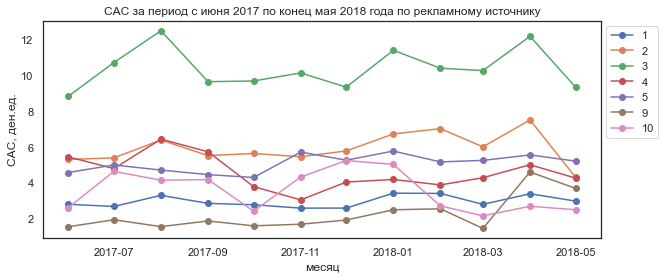

In [121]:
cac_source_pivot = report_source_new.pivot_table(index=['source_id', 'first_buy_month'],
                                                 values='cac', 
                                                 aggfunc='mean').reset_index()

fig, ax = plt.subplots(figsize=(10,4))
ax.set(title='CAC за период с июня 2017 по конец мая 2018 года по рекламному источнику',
       xlabel='месяц', ylabel='CAC, ден.ед.')
for source in cac_source_pivot['source_id'].unique():
    ax.plot(cac_source_pivot.query('source_id == @source')['first_buy_month'], 
            cac_source_pivot.query('source_id == @source')['cac'], 'o-', label=source)
ax.grid=True
ax.legend(bbox_to_anchor=(1, 1));

In [122]:
cac_source_mean = cac_source_pivot.pivot_table(index='source_id',
                                              values='cac',
                                              aggfunc='mean').reset_index()

cac_source_mean['cac'] = cac_source_mean['cac'].round(2)
cac_source_mean.sort_values(by='cac', ascending=False).reset_index(drop=True)

,source_id,cac
0,3,10.39
1,2,5.93
2,5,5.09
3,4,4.58
4,10,3.56
5,1,2.97
6,9,2.25


Самой высокой стоимостью привлечения пользователя является третий источник (CAC = 10,39 ден.ед.). Далее следуют второй (5,93 ден.ед.), пятый (5,09 ден.ед.) и четвёртый (4,58 ден.ед.) рекламные источники. Наиболее дешёвыми по стоимости привлечения пользователя оказались десятый (3,56 ден.ед.), первый (2,97 ден.ед.) и девятый (2,25 ден.ед.) рекламные источники.

Подобный порядок распределения CAC характерен практичесик для всего периода (за исключением единичных случаев). Однако, в отдельные периоды (ноябрь 2017-январь 2018 года) десятый источник обходил по величине стоимости привлечения четвёртый источник; а в отдельные периоды (февраль-май 2018 года) - обходился дешевле первого источника.

#### Окупаемость расходов на рекламу (ROMI)

У нас имеются данные о том, сколько приносят денег покупатели из каждой когорты (ltv), и данные о том, сколько стоило привлечение одного покупателя из каждой когорты (cac). Рассчитаем для когорт показатель ROMI.

In [123]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
romi = report_new.pivot_table(index='first_buy_month', 
                              columns='lifetime', 
                              values='romi', 
                              aggfunc='mean')

romi.cumsum(axis=1).round(2).fillna('')

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


Июньская когорта окупилась на шестой месяц; сентябрьская когорта окупилась на третий месяц. Все остальные когорты не окупились. Рассчитаем, как быстро, в среднем, окупаются когорты.

In [124]:
romi.cumsum(axis=1).mean(axis=0)

lifetime
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

В среднем, когорты окупаются к концу девятого-десятого месяца. Таким образом, требуется пересмотреть рекламные кампании: либо увеличить расходы на те, которые имеют отдачу, превышающую вложения; либо не вкладывать в те, которые имеют меньшую отдачу; либо оба варианта в совокупности. Рассмотрим ROMI по рекламным источникам.

In [125]:
report_source_new['romi'] = report_source_new['ltv'] / report_source_new['cac']
report_source_new['lifetime'] = ((report_source_new['buy_month'] - report_source_new['first_buy_month']) /
                                 np.timedelta64(1, 'M')).round().astype('int')

In [126]:
romi_source = report_source_new.pivot_table(index='source_id',
                                            columns='costs_month', 
                                            values='romi', 
                                            aggfunc='mean')

romi_source.cumsum(axis=1)

costs_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,1.235266,1.823685,2.478138,4.479460,5.024465,5.736104,6.195983,6.697577,7.168443,8.526729,9.845266,11.871840
2,0.632012,0.983189,1.270685,2.224651,2.528248,2.809002,3.399707,3.643450,3.853736,4.484067,5.058512,6.718898
3,0.194035,0.287255,0.393751,0.669803,0.760118,0.869389,0.968242,1.079559,1.200472,1.405672,1.658199,2.180140
4,0.418780,0.662992,0.888582,1.424801,1.644522,2.036809,2.254554,2.502417,2.814856,3.259152,3.919690,5.038626
5,0.523435,0.720896,0.989002,1.627282,1.843164,2.063758,2.570504,2.805209,3.046602,3.487696,4.055093,4.900793
9,0.624413,1.333671,1.980379,2.471244,2.990960,3.601475,4.038155,4.347099,4.826659,5.625607,6.364757,7.476748
10,0.541988,0.707736,0.907116,1.018973,1.207826,1.378677,1.507792,1.641380,1.917192,2.495031,3.010588,4.499072


Окупаемость расходов на рекламу характеризуется следующими перидами. Первый источник окупается сразу же в первый месяц (в июне 2017 года); девятый источник - во второй месяц (в июле 2017); второй источник - в третий месяц; десятый, четвёртый и пятый источники - в четвёртый (сентябрь 2017 года). Третий источник окупился только в январе 2018 года, то есть через 8 месяцев после старта рекламной кампании. Поскольку это метрики для 1 пользователя, мы можем предположить, что третий источник был слишком дорогим (суммарные затраты по немудействительно в несколько раз превышали затраты на другие источники на протяжении всего периода); и стоимость привлечения клиента была слишком высока. Таким образом, показатель ROMI по данному источнику занизил совокупный показатель ROMI.

### Вывод по маркетинговым метрикам <a id='step_3.6></a>

**Совокупные затраты на рекламу** = 329131,62 ден.ед. **Средняя стоимость привлечения одного пользователя (CAC)** = 9,15 ден.ед. В среднем, **когорты окупаются** к концу девятого-десятого месяца.

Больше всего денег было потрачено на *3 рекламный источник* (141321,63 ден.ед), чуть меньше - на *4 источник* (61073,6 ден.ед.), *5 источник* (51757,1 ден.ед.) и *2 источник* (42806,04 ден.ед.). На *1 рекламный источник* привлечения посетителей потратили 20833,27 ден.ед. И на *10 и 9 источники* потратили 5822,49 ден.ед. и 5517,49 ден.ед., соответственно.

Реклама проводилась периодически. В большей степени общие тенденции рекламных затрат по источникам совпадают с тенденциями по датам проведения рекламных кампаний. Таким образом, можем сделать вывод о том, что порядок затрат по рекламным источникам сохранялся на протяжении всего периода.

Больше всего денег было затрачено на рекламу в декабре 2017 года (однако, и многие метрики в этот месяц значительно увеличились): 38315,35 ден.ед.; высоки затраты были и в ноябре 2017 года (37907,88 ден.ед.), и в октябре 2017 года (36322,88 ден.ед.). Чуть ниже были затраты в последующие 3 месяца: январь (33518,52 ден.ед.), февраль (32723,03 ден.ед.) и март (30415,27 ден.ед.) 2018 года. На чуть меньшем уровне держались затраты других трёх месяцев: сентябрь 2017 года (24368,91 ден.ед.), апрель (22289,38 ден.ед.) и май (22224,27 ден.ед.) 2018 года. И меньше всего было потрачено на рекламу в летние месяцы: июль (18240,59 ден.ед.), июнь (18015 ден.ед.) и август (14790,54) 2017 года.

Динамика количества покупок практически полностью совпадает с динамикой рекламных затрат по месяцам (что видно и по соответствующему коэффициенту корреляции), а вот на средний чек затраты на рекламу практически не влияют.

Самыми дорогими по стоимости привлечения оказались пользователи августовской когорты (CAC = 11 ден.ед.). Примерно равны по показателю CAC когорты января 2018 и апреля 2018 (9,9 и 9,8 ден.ед., соответственно). Далее по уменьшению показателя идут июльская, сентябрьская и ноябрьская когорты (9,5, 9,4 и 9,3 ден.ед., соответственно). Ещё дешевле обошлись пользователи февральской (9 ден.ед.), декабрьской (8,7 ден.ед.) и мартовской (8,6 ден.ед.) когорт. И самыми дешёвыми по стоимости привлечения оказались пользователи октябрьской (CAC = 8,4 ден.ед.) и майской когорт (7,4 ден.ед.).

Самой высокой стоимостью привлечения пользователя является *3 источник* (CAC = 10,39 ден.ед.). Далее следуют *2 источник* (5,93 ден.ед.), *5 источник* (5,09 ден.ед.) и *4 источник* (4,58 ден.ед.). Наиболее дешёвыми по стоимости привлечения пользователя оказались *10* (3,56 ден.ед.), *1* (2,97 ден.ед.) и *9* (2,25 ден.ед.) *рекламные источники*.

Подобный порядок распределения CAC характерен практичесик для всего периода (за исключением единичных случаев). Однако, в отдельные периоды (ноябрь 2017-январь 2018 года) *10 источник* обходил по величине стоимости привлечения *4 источник*; а в отдельные периоды (февраль-май 2018 года) - обходился дешевле *1 источника*.

Июньская когорта окупилась на шестой месяц; сентябрьская когорта окупилась на третий месяц. Все остальные когорты не окупились. Таким образом, требуется пересмотреть рекламные кампании: либо увеличить расходы на те, которые имеют отдачу, превышающую вложения; либо не вкладывать в те, которые имеют меньшую отдачу; либо оба варианта в совокупности. Рассмотрим ROMI по рекламным источникам.

Окупаемость расходов на рекламу характеризуется следующими перидами. *1 источник* окупается сразу же в первый месяц (в июне 2017 года); *9 источник* - во второй месяц (в июле 2017); *2 источник* - в третий месяц; *10, 4 и 5 источники* - в четвёртый (сентябрь 2017 года). *3 источник* окупился только в январе 2018 года, то есть через 8 месяцев после старта рекламной кампании. Поскольку это метрики для 1 пользователя, мы можем предположить, что *3 источник* был слишком дорогим (суммарные затраты по нему действительно в несколько раз превышали затраты на другие источники на протяжении всего периода); и стоимость привлечения клиента была слишком высока. Таким образом, показатель ROMI по данному источнику занизил совокупный показатель ROMI.

## Общий вывод <a id='step_4'></a>

### Метрики для Яндекс.Афиши <a id='step_4.1'></a>

Число посещений сайта составило: 
- **DAU (в день)** = 907; 
- **WAU (в неделю)** = 5716; 
- **MAU (в месяц)** = 23228. 

**Sticky factor** по отношению к:
- **недельной аудитории** = 15,88%;
- **месячной аудитории** = 3,91%. 

**Среднее количество посещений сайта в день**:
- **общее** = 1003;
- **на одного пользователя** = 1. 

**Средняя длительность одной сессии (ASL)** = 60 сек. 

Показатель **Retention Rate** = 6,5%; показатель **Churn Rate** = 93,5%.

**Среднее время между покупкой и первым входом** пользователя на сайт = 0 дней. **Среднее количество покупок** за период = 3544. **Средний чек** = 5 ден.ед. 

Показатель **LTV**:
- **средний по всем когортам** = 4,5-6 ден.ед.;
- **максимальный для июньской когорты** = 11,88;
- **максимальный для сентябрьской когорты** = 13,43 ден.ед.

**Совокупные затраты на рекламу** = 329131,62 ден.ед. **Средняя стоимость привлечения одного пользователя (CAC)** = 9,15 ден.ед. **Период окупаемости когорт** = 9-10 месяцев.

### Общая динамика показателей <a id='step_4.2'></a>

Заметим, что сумма посещений с карманных и стационарных устройств не равна соответствующим метрикам по всей выборке. Это говорит о том, что **некоторые пользователи заходят на сайт и с карманного устройства, и со стационарного устройства**.

**Динамика количества сессий, приходящихся на одного пользователя, за день близка к динамике ежедневных сессий** (мы видим такие же сильные всплески в те же даты, и такой же спад в начале апреля 2018).  

Кроме того, было выявлено, что **имеется очень большое число сессий продолжительностью 0 секунд**. То есть пользователи открыли и сразу же закрыли сайт. Это может быть связано со случайным "кликом", либо с проблемами в загрузке сайта (пользователь не дождался, когда сайт откроется и закрыл его). Мода также учитывает случайность такого являения, то есть это не влияет на результат метрики.

При анализе лояльности клиента сайту было выявлено, что **в августе 2017 года наблюдалось снижение пользовательской активности**. Это может быть связано с какими-то иными факторами, не имеющими отношение к приверженности пользователей. В сентябре наблюдался рост показателей для июньской и августовской когорт; но пользователи из июльской когорты сократили посещение. В октябре видим рост по всем когортам, кроме августовской. Так, по всем когортам наблюдается спад активности на второй месяц использования сайта, что должно быть учтено в маркетинговой компании Яндекс.Афиши. Самыми активными пользователями на следующий месяц после первого посещения были сентябрьские пользователи, а самыми неактивными - пользователи, впервые зашедшие в марте и апреле 2018 года. 

**В некоторые месяцы даже наблюдался прирост пользователей, то есть о платформе вспомнили пользователи, которые на неё давно не заходили**. Возможно, это было как раз связано с рекламными кампаниями. Апрель 2018 года характерен очень большим количеством ушедших пользователей. Как мы видели ранее, это могло быть связано с какими-то техническими работами или проблемами, когда посещений сайта не было. Подобное событие могло отпугнуть пользователей. При этом для пользователей на стационарных устройствах наблюдается схожая динамика, что и для всех пользователей. Для пользователей карманных устройств наблюдаем следующие особенности. Отток пользователей в апреле 2018 года был намного сильнее, чем отток пользователей стационарных устройств. Скорее всего, это связано с порядком чисел (поскольку пользователей стационарных устройств на порядок больше, их изменение будет относительно небольшим к большой выборке; а для пользователей карманных устройств даже незначительное изменение будет относительно больше из-за небольших величин предыдущего периода).

**Достаточно большое число пользователей совершает покупку в тот же день, что и входит на сайт, вне зависимости от типа устройства и рекламного источника**. Есть и те, кто покупает на несколько дней позже, и даже практически через год после первого входа (363 дня). Однако, общие закономерности показывают, что пользователи входят на сайт с целью совершения покупки; соответственно, главным в рекламной кампании должно быть привлечение клиента к сайту. Также было выявлено, что 28555 пользователей заходило на сайт, но не совершило покупок. Для таких пользователей характерны сессии длительностью 0 секунд. То есть они либо случайно зашли на сайт, либо имели проблемы с его загрузкой и моментально уходили с сайта.

**Похожая тенденция проявляется и в количестве покупателей**. После первого месяца количество покупателей в когортах (когорты были выделены по месяцу первой покупки) значительно снижается. Практически во всех когортах число покупателей периодически начинает незначительно расти; а в ноябре 2017 - январе 2018 и апреле 2018 года снижается. Причины этого могут быть теми же, что и для снижения пользовательских сессий на сайте в те же периоды. Если не брать во внимание месяц первой покупки и покупки в следующий месяц после первой покупки, пользователи октябрьской когорты составляли большую долю покупателей даже через несколько месяцев после первой покупки.

**По количеству покупок без разделения когорт мы видим следующие тенденции**. Наблюдался спад покупок в августе 2017 года, затем был сильный скачёк, в результате которого среднее количество покупок пользователей достигло "пика" в декабре 2017 года. Затем произошёл спад до уровня, который также продержался три месяца, после чего в апреле 2018 года было сильное падение. В мае 2018 года показатель поднялся, почти достигнув уровня января-марта 2018 года. В июне 2018 года была всего одна покупка, но, возможно, это связано с неполнотой собранных данных по последнему месяцу анализируемого периода.

**По величине среднего чека выделяется июльская когорта, сентябрьская когорта и декабрьская когорта: там величина среднего чека наиболее высокая в последующие за первой покупкой месяцы**. Особо следует выделить средний чек в декабре для сентябрьской когорты: он составил 138,67 ден.ед. Наблюдаем следующую динамику величины среднего чека по каждому пользователю: в июле 2017 года средний чек вырос, затем снизился. В сентябре 2017 снова наблюдался небольшой рост, после чего был спад показателя до величины сентября (около 6 ден.ед.), который продержался 2 месяца. В декабре был очень большой рост среднего чека, что может быть связано с сезонностью (новогодние мероприятия), после чего произошёл значительный спад до уровня июня 2017 года. В феврале снова был достигнут уровень августа и октября-ноября 2017 года; затем был небольшой рост; после чего в апреле-мае 2018 года показатель вернулся к отметке около 6 ден.ед.; а в июне 2018 года был очень сильный спад до 3,5 ден.ед. Однако, ранее мы указывали на то, что показатель июня 2018 может быть недостоверным из-за недостатка данных по покупкам.

Необходимо отметить, что при расчёте LTV мы обнаружили отсутствие данных о маржинальности покупок, соответственно, было сделано предположение о том, что **маржинальность равна единице, а себестоимость услуг нулевая**. Соответственно, показатель LTV был рассчитан на основе выручки, а не валовой прибыли. Когортный анализ динамики LTV показал, что средний пользователь приносит больше всего денег в нулевой период (то есть в месяц первой покупки). Июньская когорта является самой стабильной по показателю, а на третий месяц после первой покупки сентябрьской когорты наблюдается очень большое значение LTV. Именно поэтому эти две когорты были отдельно выделены в качестве метрик.

**Реклама проводилась периодически**. Больше всего денег было затрачено на рекламу в декабре 2017 года (однако, и многие метрики в этот месяц значительно увеличились): 38315,35 ден.ед.; высоки затраты были и в ноябре 2017 года (37907,88 ден.ед.), и в октябре 2017 года (36322,88 ден.ед.). Чуть ниже были затраты в последующие 3 месяца: январь (33518,52 ден.ед.), февраль (32723,03 ден.ед.) и март (30415,27 ден.ед.) 2018 года. На чуть меньшем уровне держались затраты других трёх месяцев: сентябрь 2017 года (24368,91 ден.ед.), апрель (22289,38 ден.ед.) и май (22224,27 ден.ед.) 2018 года. И меньше всего было потрачено на рекламу в летние месяцы: июль (18240,59 ден.ед.), июнь (18015 ден.ед.) и август (14790,54) 2017 года.

**Динамика количества покупок практически полностью совпадает с динамикой рекламных затрат по месяцам** (что видно и по соответствующему коэффициенту корреляции), а вот **на средний чек затраты на рекламу практически не влияют**.

**Самыми дорогими по стоимости привлечения оказались пользователи августовской когорты** (CAC = 11 ден.ед.). Примерно равны по показателю CAC когорты января 2018 и апреля 2018 (9,9 и 9,8 ден.ед., соответственно). Далее по уменьшению показателя идут июльская, сентябрьская и ноябрьская когорты (9,5, 9,4 и 9,3 ден.ед., соответственно). Ещё дешевле обошлись пользователи февральской (9 ден.ед.), декабрьской (8,7 ден.ед.) и мартовской (8,6 ден.ед.) когорт. И самыми дешёвыми по стоимости привлечения оказались пользователи октябрьской (CAC = 8,4 ден.ед.) и майской когорт (7,4 ден.ед.).

**Июньская когорта окупилась на шестой месяц; сентябрьская когорта окупилась на третий месяц. Все остальные когорты не окупились**. Таким образом, требуется пересмотреть рекламные кампании: либо увеличить расходы на те, которые имеют отдачу, превышающую вложения; либо не вкладывать в те, которые имеют меньшую отдачу; либо оба варианта в совокупности. Однако изучение показателя по рекламным источникам имело другой результат.

### Показатели по типам устройств, с которых заходят пользователи <a id='step_4.3'></a>

#### Общие тенденции

Показатели вовлечённости пользователей (**sticky factor**) практически равны на разных устройствах и близки к значению по всей выборке, однако на стационарных устройствах они незначительно выше, чем на карманных как для недельной аудитории, так и для месячной аудитории.

**Среднее количество посещений** сайта **в день**, приходящихся **на одного пользователя**, составляет 1 сессию, вне зависимости от того, с какого устройства входит пользователь. Однако, разница проявлялась в динамике.

По количеству сессий имеется спад для всех устройств: в конце марта-начале апреля - сразу же после подъёма. Возможно, имелись какие-то технические неполадки с сайтом, и люди не могли на него "зайти". Если это произошло сразу после рекламной компании, это негативно отразилось на показателях привлечения по результатам кампании, так как могло снизить доверие пользователей к данному ресурсу и потерять тех, кто пришёл "по горячим следам".

Показатели по количеству покупок для пользователей, использующих разные типы устройств, изменялись симметрично, но с разным темпом роста.

До сентября 2017 года величина среднего чека имела схожую динамику для различных типов устройств. 

Наибольшее значение LTV наблюдалось в июне 2017 года для всех типов устройств. Далее показатель снижался, однако для стационарных устройств был внезапный рост в декабре 2017 года. В целом же показатель LTV для пользователей стационарных устройств был близок к показателю для пользователей карманных устройств. 

Было выявлено, что пользователи карманных устройств более чувствительны к любым изменениям сайта (положительным и отрицательным), чем пользователи стационарных устройств, что отразилось в динамике показателей.

#### Особенности, характерные для desktop device

Для пользователей с desktop device число посещений сайта **DAU (в день)** = 659 ; **WAU (в неделю)** = 4129; **MAU (в месяц)** = 16724. **Среднее количество посещений сайта в день** для пользователей desktop device = 711. Показатель **Retention Rate** = 6,8%. Это значит, что в среднем около 6,8% пользователей desktop device возвращается на сайт на следующий месяц после первого посещения. Показатель **Churn Rate** = 93,2%. Это значит, что в среднем около 93,2% пользователей desktop device прекращает использование сайта на следующий месяц после первого посещения.

Количество сессий с desktop device имеет очень близкую динамику со всеми сессиями. Скорее всего, это связано с тем, что пользователей на таких устройствах заходит больше - и это имеет больший вклад в динамику совокупного показателя. Для данной категории пользователей сложно выделить когорту, которая была самой активной на следующий месяц после первого посещения. В целом, все пользователи были относительно активны. Но самыми неактивными были пользователи, впервые зашедшие в марте 2018 года.

По количеству покупок имеем те же закономерности для пользователей desktop device, что и для общей выборки: наибольшее число покупок во все периоды совершала октябрьская когорта. С сентября 2017 года доля покупок на данном типе устройств значительно выросла. Однако после того, как доля покупок начала расти, средний чек для этого типа устройств снизился, в то время как для карманных устройств он оставался практически на том же уровне. 

В ноябре 2017 года имелась иная динамика: средний чек пользователей desktop device имел сильный "скачёк" вверх и достиг максимального значения около 22,5. В январе 2018 года средний чек вернулся к близкому до "скачка" значению, после чего начал расти до марта 2018 года. 

В апреле-мае 2018 года наблюдалось падение среднего чека для всех устройств. В целом, динамика среднего чека пользователей карманных устройств имеет более плавную динамику и менее резкие изменения, чем динамика среднего чека пользователей стационарных устройств.

#### Особенности, характерные для touch device

Для пользователей с touch device число посещений сайта **DAU (в день)** = 252; **WAU (в неделю)** = 1634; **MAU (в месяц)** = 6825. **Среднее количество посещений** сайта **в день** для пользователей touch device = 278. Показатель **Retention Rate** = 6,2%. Это значит, что в среднем около 6,2% пользователей touch device возвращается на сайт на следующий месяц после первого посещения. Показатель **Churn Rate** = 93,8%. Это значит, что в среднем около 93,8% пользователей touch device прекращает использование сайта на следующий месяц после первого посещения.

Количество сессий с touch device имеет несколько иную динамику и меньше колебаний по ежедневным посещениям сайта, чем количество сессий с desktop device. Имеется заметный "всплеск" в конце ноября-начале декабря. Анализ показал, что в этот момен было проведено несколько рекламных кампаний, которые были эффективны. Также был небольшой "всплеск" в середине июля, начале февраля, ближе к концу марта, в конце мая. Тем не менее, в среднем посетители реже заходят с touch device в день, чем с desktop device. Хотя есть дни, в которые количество сессий с desktop device было равно количеству сессий для одного пользователя с touch device.

Активность пользователей, заходящих на сайт с touch device, была ниже, чем использующих desktop device. Самыми неактивными в последующие месяцы оказались пользователи, посетившие сайт в марте и апреле 2018 года и в июле 2017 года. 

При этом больший разброс количества дней до покупки также характерен для пользователей touch device (для 75% пользователей устройств этот период составил до 100 дней). Это может быть связано с неудобством совершения покупки с мобильной версии сайта. Таким образом, пользователи могут отложить покупку и совершить её с desktop device. Однако, часть таких пользователей может уйти в этом процессе, либо забыть о покупке. Для пользователей touch device нет таких больших изменений в количестве покупок после первого месяца (на второй месяц), как для пользователей desktop device. Октябрьская когорта также характеризуется наибольшим значением количества покупок. Самый низкий показатель у августовской когорты.

По среднему чеку для touch device наблюдалась неизменность (в то время как для desktop device показатель колебался). Но в ноябре 2017 года имелась иная динамика: средний чек пользователей desktop device имел сильный "скачёк" вверх, а для пользователей touch device он сократился до 7,5, где продержался до февраля 2018 года.

### Показатели по типам рекламных источников <a id='step_4.4'></a>

#### 1 источник

Вне зависимости от типа устройств 1 источник **по числу пользователей** находился на 3 месте с конца (если мы исключаем источники, которые привели по 1 челоеку). Но в то же время источник привёл клиентов, которые оказались наиболее "привержены" сайту как в разрезе недельной аудитории, так и для месячной аудитории.

Источник является лидирующим по **ежедневному количеству сессий**: пользователи, пришедшие по нему неоднократно пользуются сайтом в течение дня. 

**Число дней до первой покупки** пользователей из 1 источника больше 0, но не очень высоко: как правило, пользователь делает покупку в течение недели после первого входа.

При этом **по числу покупок** данный источник находится в середине рейтинга по всем источникам.

Анализ динамики **среднего чека** показал, что для данного источника характерна практически самая высокая величина на протяжении долгого периода. Однако, в феврале-марте 2018 года средний чек пользователей из данного источника был ниже значений других месяцев. 

Кроме того, 1 источник был одним из самых доходных по **показателю LTV**.

**Маркетинговые затраты** на данный рекламный источник составили 20833,27 ден.ед. Это среднее, по сравнению с другими источниками, значение.

1 источник оказался одним из самых дешёвых по **стоимости привлечения пользователя** (CAC = 2,97 ден.ед.).

**Окупаемость расходов на рекламу** для данного источника происходит в 1-й месяц (то есть в июне 2017 года).

#### 2 источник

Второй рекламный источник по многим показателям схож с первым источником.

Он немного выше по **числу посетителей** сайта в день, неделю и месяц. Но также характеризуется "приверженностью" пользователей сайту как для недельной, так и для месячной аудитории.

По **ежедневному количеству сессий** второй источник отстаёт от первого, но значения по нему также превышают единицу, которая характерна для ряда источников.

**Число дней до первой покупки** у пользователей из 2 источника близко к соответствующему показателю для 1 источника.

**Количество покупок** во все месяцы рассматриваемого периода по данному источнику практически равно соответствующему показателю по первому источнику. 

Данный источник является лидером по **среднему чеку** на протяжении всего периода.

**Показатель LTV** для источника был близок к показателю для 1 источника: они оба были лидерами по метрике.

**Маркетинговые затраты** на 2 источник также являются средними, относительно всех затрат на рекламу, но в 2 раза превосходят маркетинговые затраты по 1 источнику: 42806,04 ден.ед.

Соответственно, данный источник характеризуется высокой **стоимостью привлечения** пользователя (CAC = 5,93 ден.ед.).

**Окупаемость расходов на рекламу** для 2 источника происходит в 3-й месяц (август 2017 года).

#### 3 источник

Третий источник рекламы находится на втором месте по **числу посетителей** сайта: 132 пользователя в день, 1565 - в неделю, и 6758 - в месяц. Этот источник лидировал на протяжении долгого периода, но затем его превзошло число пользователей из 4 рекламного источника. Лидирует данный рекламный источник и по числу пользователей, "приверженных" продукту.

**Ежедневное количество сессий** для источника составляет чуть более 1 раза в день. 

По **количеству дней до первой покупки** 3 источник чуть хуже, чем 1 и 2: пользователю требуется больше времени.

Также источник характеризуется наибольшим **количеством покупок**. Причём до сентября 2017 года включительно больше покупали пользователи из 3 источника, а в последующие периоды - пользователи из 4 источника. 

Пользователи из 3 источника находятся на среднем уровне по **среднему чеку**.

По **показателю LTV** источник показал среднюю доходность.

Для данного источника характерны самые высокие **маркетинговые затраты**: 141321,63 ден.ед.

Соответственно, он характеризуется и самой высокой **стоимостью привлечения пользователя**: CAC = 10,39 ден.ед. 

Всё это отразилось на длительном **периоде окупаемости** расходов на рекламу: это единственный источник, который окупается только через 8 месяцев (январь 2018 года). Поскольку затраты на привлечение пользователя по данному источнику были слишком высоки, он повлиял на средний показатель окупаемости затрат, значительно его "занизив".

#### 4 источник

Многие показатели, характерные для 4 источника, близки к показателям, характерным для 3 источника.

4 рекламный источник лидирует по **количеству пользователей**, привлечённых на сайт (275 в день, 1829 в неделю и 7765 в месяц). При этом превышение показателей 3 источника становится тем незначительней, чем более долгосрочный период мы рассматриваем. Как и 3 источник, 4 источник наиболее эффективен с точки зрения числа пользователей "приверженных" продукту. При этом для карманных устройств существует явно выраженное преобладание посетителей, пришедших по 4 источнику рекламы. Этот отрыв выражен сильнее, чем в случае со стационарными устройствами.

**Ежедневное количество сессий** для источника также близко к 1.

Однако, источник "проседает" по **количеству дней до первой покупки**: до 75% пользователям, пришедшим из 4 рекламного источника, требуется до 20 дней с первого посещения сайта для совершения покупки.

Как и 3 источник, 4 источник является самым большим по **количеству покупок**. После сентября 2017 года он занял лидирующую позицию по показателю.

**Средний чек** пользователей из 4 источника практически идентичен среднему чеку пользователей из 3 источника.

**Показатель LTV** также близок к показателю для 3 источника, немного его превышая.

По **маркетинговым затратам** 4 источник занимает второе место: они составили 61073,6 ден.ед. и оказались более чем в 2 раза ниже затрат на 3 источник.

По **стоимости привлечения** пользователей 4 источник оказался достаточно недорогим: CAC = 4,58 ден.ед.

**Период окупаемости** расходов на рекламу - четвёртый месяц (сентябрь 2017 года).

#### 5 источник

5 источник находится на третьем месте по **количеству пользователей**. При этом пользователи характеризуются достаточно высокой "приверженностью" сайту. 

**Ежедневное количество сессий** для 5 источника превышает единицу, то есть пользователи неоднократно заходят на сайт в течение дня.

По разбросу **количества дней до первой покупки** 5 источник схож с 1, 2 и 3 рекламными источниками. 

Также 5 источник очень эффективен с точки зрения **числа покупок**. Он немного хуже 3 и 4 источников, но лучше 1 и 2. 

Достаточно высокие показатели **среднего чека** ежемесячно показывали пользователи из данного рекламного источника: ниже 1 и 2 источника, но выше 3 и 4. 

5 источник характеризуется средним **уровнем доходности (LTV)**.

Он на третьем месте по **маркетинговым затратам**: 51757,1 ден.ед.

И также он на третьем месте по **стоимости привлечения пользователя**: CAC = 5,09 ден.ед.

**Окупаемость расходов на рекламу** для 5 источника происходит в четвёртый месяц (сентябрь 2017 года).

#### 6 источник

6 источник "выбивается" по показателю **количества пользователей**: имеется всего 1 пользователь (показатели идентичны для дня и недели). Тот же пользователь заходил на сайт в течение месяца (его вовлечённость равна 100%). При этом он заходил на сайт с обоих типов устройств.

Для данного рекламного источника **количество посещений** близко к нулю. Это говорит о том, что пользователь, скорее всего, случайно зашёл на сайт.

Это подтверждается и тем, что пользователь не совершил ни одной **покупки**.

Однако, и **маркетинговые затраты** на этот источник были нулевыми.

#### 7 источник

7 источник схож с 6 источникам по многим хараткеристикам, за исключением того, что в августе по этому источнику пришёл пользователь, который совершил покупку.

Соответственно, **количество пользователей** по источнику было равно 1 (показатели идентичны для дня и недели), но в течение месяца был привлечён еще один пользователь, который заходил только со стационарного устройства.

**Количество дней до первой покупки** для этого пользователя было равно нулю: он моментально совершил покупку (**число покупок** равно 1) и больше не посещал сайт (**число сесий** близко к 0).

При этом пупка характеризовалась самым низким значением **среднего чека**: всего 1,22 ден.ед., в связи с чем 7 источник был абсолютно неэффективен по **LTV**.

Однако, следует отметить, что данный источник имел нулевые **маркетинговые затраты**.

#### 9 источник

9 источник занимает предпоследнее место по **количеству пользователей** (за исключением единичных пользователей из 6 и 7 источников).

**Количество ежедневных сессий** близко к 1 по данному источнику на протяжении большей части периода, но в конце ноября-начале декабря 2017 года и в конце октября 2017 года количество сессий было близко к 2. В целом, источник "срабатывал" периодически на протяжении всего рассматриваемого периода (в моменты проведения данной рекламной кампании).

Пользователи по данному источнику - самые "нерешительные" - для многих из них **период до совершения первой покупки** составляет до 60 дней.

9 источник побудил пользователей к совершению небольшого **числа покупок**.

При этом **средний чек** по ним также был невысок (одно из самых низких значений, по сравнению с другими источниками).

**Динамика LTV** отличалась от других рекламных источников: в то время, как показатель вырос для них в декабре 2017 года, показатель для 9 источника не изменился.

Однако, на 9 источник было меньше всего **потрачено денег**: 5517,49 ден.ед.

Соответственно, он является наиболее дешёвым по **стоимости привлечения пользователя** (CAC = 2,25 ден.ед.) и достаточно высоким по **показателю ROMI**.

**Окупаемость расходов на рекламу** по 9 рекламному источнику происходит во второй месяц (июль 2017 года).

#### 10 источник

Характеристики 10 источника во многом близки характеристикам 9 источника.

Этот рекламный источник занимает последнее место по **количеству пользователей** (за исключением 6 и 7 источников). Показатели "приверженности" сайту для источника 10 также невысоки. 

По **количеству сессий** 10 источник имеет периодические "всплески" входа на сайт.

**Период до совершения первой покупки** для большого числа пользователей из 10 источника тоже очень высок: он может составлять
до 40 дней.

Данный источник хараткерен самым минимальным значением **количества покупок** из всех.

**Динамика LTV** для 10 источника схожа с динамикой показателя для 9 источника. При этом показатель LTV для 10 источника меньше, чем для 9.

10 источник находится на предпоследнем месте по величине **маркетинговых затрат**: 5822,49 ден.ед.

Соответственно, он оказался достаточно дешёвым по **стоимости привлечения пользователя**: CAC = 3,56 ден.ед. Но по этому показателю он находился на предпоследнем месте не весь период: в отдельные периоды (ноябрь 2017-январь 2018 года) 10 источник обходил по величине стоимости привлечения 4 источник; а в отдельные периоды (февраль-май 2018 года) - обходился дешевле 1 источника.

**Окупаемость расходов на рекламу** по 10 рекламному источнику происходит в четвёртый месяц (сентябрь 2017 года).

#### Ранжирование источников по показателям

Таким образом, мы показали, что источники различаются по многим показателям, превосходя другие по одним критериям, и уступая - по другим. Для того, чтобы наиболее полно оценить каждый источник и дать рекомендации маркетологам по суммам и направлениям денежных вложений, создадим таблицу с ранжированием источников по показателям, которая будет систематизировать их особенности, описанные выше.

In [127]:
rating = pd.DataFrame({'source_id': [1, 2, 3, 4, 5, 6, 7, 9, 10],
                       'dau_wau_mau': [5, 4, 2, 1, 3, 9, 8, 6, 7],
                       'sticky_factor': [3, 4, 9, 7, 8, 1, 2, 6, 5],
                       'day_visits': [5, 4, 2, 1, 3, 9, 8, 6, 7],
                       'buy_days': [3, 4, 5, 6, 2, 9, 1, 8, 7],
                       'purchases': [5, 4, 2, 1, 3, 9, 8, 6, 7],
                       'rev_per_user': [2, 1, 5, 4, 3, 9, 8, 6, 7],
                       'ltv': [2, 1, 5, 4, 3, 9, 8, 6, 7],
                       'costs': [5, 6, 9, 8, 7, 2, 1, 3, 4],
                       'cac': [4, 8, 9, 6, 7, 2, 1, 3, 5], 
                       'romi': [2, 4, 8, 6, 7, 9, 1, 3, 5]})
rating = rating.set_index('source_id')
rating['sum'] = rating.sum(axis=1)
rating['mean'] = rating.mean(axis=1).astype('int')
rating.sort_values(by=['mean', 'sum'])

,dau_wau_mau,sticky_factor,day_visits,buy_days,purchases,rev_per_user,ltv,costs,cac,romi,sum,mean
source_id,,,,,,,,,,,,
1,5,3,5,3,5,2,2,5,4,2,36,6
2,4,4,4,4,4,1,1,6,8,4,40,7
4,1,7,1,6,1,4,4,8,6,6,44,8
5,3,8,3,2,3,3,3,7,7,7,46,8
7,8,2,8,1,8,8,8,1,1,1,46,8
9,6,6,6,8,6,6,6,3,3,3,53,9
3,2,9,2,5,2,5,5,9,9,8,56,10
10,7,5,7,7,7,7,7,4,5,5,61,11
6,9,1,9,9,9,9,9,2,2,9,68,12


Поскольку у нас нет информации о важности каждого из факторов для бизнеса, оставим итоговую таблицу с рейтингом в таком виде; и сделаем на её основе рекомендации.

## Рекомендации маркетологам Яндекс.Афиши <a id='step_5'></a>

1. Наиболее эффективными источниками являются **1 и 2 рекламные источники**: они имеют средние позиции по всем показателям. Но большей эффективностью обладает **1 источник**, поскольку имеет большую отдачу от маркетинговых затрат и стоит дешевле.

2. Рекламные **источники 4 и 5** можно использовать в случае, когда мы имеем определённые цели: 
    - *Источник 4* хорош в привлечении покупающих пользователей, но его недостаток состоит в слишком высоких затратах. Рекомендуется по возможности рассмотреть сокращение затрат по данному источнику (аналогичные платформы, условия договоров и т.д.);
    - *Источник 5* также имеет слишком высокие затраты (те же рекомендации по затратам, что и для 4 источника), но он побуждает достаточно большое число покупающих пользователей быстро совершать покупки, то есть имеет моментальную отдачу.

3. **Источник 7** не рекомендуется использовать, поскольку это разовая возможность привлечь покупателя. Хотя он и не имеет затрат, и отдача от него моментальная, но несколько человек не стоят затрачиваемых усилий по реализации рекламы через этот источник.

4. **Источник 9** рекомендуется использовать в случае, когда бюджет на рекламу сильно ограничен. Он не приносит большого числа пользователей и покупателей, но и не имеет больших затрат. Этот источник самый эффективный при очень низком бюджете на рекламу.

5. По **3 рекламному источнику** настоятельно рекомендуется пересмотреть затраты. Это очень эффективный источник по большинству параметров, но его эффект значительно меньше, чем затраты на его реализацию. Таким образом, каждый привлечённый клиент невыгоден для бизнеса; и таких клиентов очень много.

6. Рекомендуется исключить из применения **10 и 6 рекламные источники**. *10 источник* является нестабильным, и заменяемым *9 источником*, который более эффективен по показателям бизнеса. *6 источник* абсолютно неэффективен, хоть и не стоил денег, - он не стимулирует к покупкам и даже к посещениям сайтов.

7. Также следует принимать во внимание при разработке маркетинговой стратегии, что в большинстве случаев пользователи склонны **моментально совершать покупки**; поэтому необходимо в первую очередь привлекать клиентов; и только затем - стимулировать их к покупке.

8. Также рекомендуется **не допускать сбоев** в работе сайта, поскольку это может привести к потере большого числа пользователей и потенциальных покупателей.

9. Следует убедиться, что возможность совершения покупки работает стабильно как с мобильного, так и со стационарного устройства. Но в текущих реалиях строить рекламную кампанию, учитывая что основные пользователи заходят со **стационарных устройств**.